# Sentiment Analysis EDA - Topic and Sentiment Visualization

This notebook investigates sentiment folders and creates 15x15 visualizations showing topics and their corresponding sentiments over time periods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
from datetime import datetime, timedelta
import json

In [2]:
# Define paths
CLEANED_DATA_PATH = r"C:\Users\KemalUtkuLekesiz\Documents\Kod\Okul\NLP\SentimTA\data_sentim\cleaned"
SENTIMENT_FOLDER_PREFIX = "sentiment_"

# Get all sentiment folders
sentiment_folders = [f for f in os.listdir(CLEANED_DATA_PATH) 
                    if f.startswith(SENTIMENT_FOLDER_PREFIX) and os.path.isdir(os.path.join(CLEANED_DATA_PATH, f))]

print(f"Found {len(sentiment_folders)} sentiment folders:")
for folder in sentiment_folders[:5]:  # Show first 5
    print(f"  - {folder}")
if len(sentiment_folders) > 5:
    print(f"  ... and {len(sentiment_folders) - 5} more")

Found 26 sentiment folders:
  - sentiment_gdelt_3m_20170101_to_20241231
  - sentiment_gdelt_amazon_20170101_to_20241231
  - sentiment_gdelt_american_express_20170101_to_20241231
  - sentiment_gdelt_amgen_20170101_to_20241231
  - sentiment_gdelt_apple_20170101_to_20241231
  ... and 21 more


In [3]:
def load_data_for_folder(folder_name):
    """
    Load and merge topic, sentiment, and date data for a given sentiment folder.
    
    Args:
        folder_name (str): Name of the sentiment folder
        
    Returns:
        tuple: (merged_df, topic_names_dict) or (None, None) if error
    """
    try:
        # Extract company name from folder name
        # e.g., "sentiment_gdelt_apple_20170101_to_20241231" -> "apple"
        company_name = folder_name.replace("sentiment_", "").split("_")[1]
        
        # Paths
        sentiment_folder_path = os.path.join(CLEANED_DATA_PATH, folder_name)
        original_data_path = os.path.join(CLEANED_DATA_PATH, f"gdelt_{company_name}.csv")
        
        # Load original data with dates
        original_df = pd.read_csv(original_data_path)
        original_df['Date'] = pd.to_datetime(original_df['Date'])
        
        # Load topic and sentiment data
        topics_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_topics.csv"))
        sentiments_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_sentiments.csv"))
        
        # Load topic names if available
        topic_names_path = os.path.join(sentiment_folder_path, "topic_names.json")
        topic_names = {}
        if os.path.exists(topic_names_path):
            with open(topic_names_path, 'r') as f:
                topic_names = json.load(f)
        
        # Create normalized versions for merging (lowercase, stripped)
        original_df['headline_normalized'] = original_df['Headline'].str.lower().str.strip()
        topics_df['headline_normalized'] = topics_df['headline'].str.lower().str.strip()
        sentiments_df['headline_normalized'] = sentiments_df['headline'].str.lower().str.strip()
        
        # Merge data on normalized headlines
        merged_df = original_df.merge(topics_df, left_on='headline_normalized', right_on='headline_normalized', how='inner')
        merged_df = merged_df.merge(sentiments_df, left_on='headline_normalized', right_on='headline_normalized', how='inner')
        
        # Clean up columns - keep original headline
        merged_df = merged_df.drop(['headline_x', 'headline_y', 'headline_normalized'], axis=1)
        merged_df = merged_df.rename(columns={'Headline': 'headline'})
        
        print(f"Loaded data for {company_name}: {len(merged_df)} records from {merged_df['Date'].min()} to {merged_df['Date'].max()}")
        
        return merged_df, topic_names
        
    except Exception as e:
        print(f"Error loading data for {folder_name}: {str(e)}")
        return None, None

In [28]:
def create_sentiment_topic_heatmap(folder_name, random_seed=None):
    """
    Creates a 15x15 heatmap showing topics and sentiments for a 15-day period.
    
    Args:
        folder_name (str): Name of the sentiment folder to analyze
        random_seed (int): Random seed for reproducible results
        
    Returns:
        tuple: (fig, ax, selected_date, date_range_info) or None if error
    """
    if random_seed:
        random.seed(random_seed)
        np.random.seed(random_seed)
    
    # Load data
    df, topic_names = load_data_for_folder(folder_name)
    if df is None:
        return None
        
    # Get unique dates and select a random one
    unique_dates = df['Date'].dt.date.unique()
    if len(unique_dates) < 15:
        print(f"Not enough dates in dataset. Found only {len(unique_dates)} unique dates.")
        return None
        
    # Select random date, ensuring we can go 15 days back
    min_valid_date = df['Date'].min().date() + timedelta(days=14)
    valid_dates = [d for d in unique_dates if d >= min_valid_date]
    
    if not valid_dates:
        print("No valid dates found (need at least 15 days of data)")
        return None
        
    selected_date = random.choice(valid_dates)
    start_date = selected_date - timedelta(days=14)
    
    print(f"Selected date: {selected_date}")
    print(f"Analyzing period: {start_date} to {selected_date} (15 days)")
    
    # Filter data for the 15-day period
    period_data = df[(df['Date'].dt.date >= start_date) & 
                     (df['Date'].dt.date <= selected_date)].copy()
    
    if len(period_data) == 0:
        print("No data found for the selected period")
        return None
        
    print(f"Found {len(period_data)} headlines in the period")
    
    # Create 15x15 grid: days (rows) x topics (columns)
    # Get the topics that actually exist in the data
    unique_topics = sorted(period_data['topic_id'].unique())
    
    # If we have more than 15 topics, take the most frequent ones
    if len(unique_topics) > 15:
        topic_counts = period_data['topic_id'].value_counts()
        unique_topics = sorted(topic_counts.head(15).index.tolist())
    
    # Note: We use only the topics that actually appear in the data period
    # This means we might have fewer than 15 topics if some don't appear in this time window
    num_topics = len(unique_topics)
    
    # Create date range for 15 days
    date_range = pd.date_range(start=start_date, end=selected_date, freq='D')
    
    # Initialize sentiment matrix (num_topics x 15 days) - FLIPPED AXES
    sentiment_matrix = np.zeros((num_topics, 15))
    
    # Fill the matrix with average sentiments
    for day_idx, date in enumerate(date_range):
        day_data = period_data[period_data['Date'].dt.date == date.date()]
        
        for topic_idx, topic_id in enumerate(unique_topics):
            topic_data = day_data[day_data['topic_id'] == topic_id]
            
            if len(topic_data) > 0:
                # Use average sentiment for that topic on that day
                avg_sentiment = topic_data['sentiment'].mean()
                sentiment_matrix[topic_idx, day_idx] = avg_sentiment  # FLIPPED: topic_idx first
            else:
                # No data for this topic on this day - use neutral (0)
                sentiment_matrix[topic_idx, day_idx] = 0  # FLIPPED: topic_idx first
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(14, max(8, num_topics * 0.6)))  # Dynamic height based on topics
    
    # Create heatmap with custom colormap (negative=red, neutral=white, positive=green)
    im = ax.imshow(sentiment_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
    
    # Customize the plot
    ax.set_title(f'Topic Sentiment Heatmap: {folder_name}\\n'
                f'Period: {start_date} to {selected_date}', 
                fontsize=14, fontweight='bold')
    
    # Set axis labels - FLIPPED
    ax.set_xlabel('Days', fontsize=12)
    ax.set_ylabel('Topics (Topic ID)', fontsize=12)
    
    # Set ticks - FLIPPED
    ax.set_xticks(range(15))
    ax.set_xticklabels([date.strftime('%m-%d') for date in date_range], rotation=45)
    
    ax.set_yticks(range(num_topics))
    # Use topic names if available, otherwise use topic IDs
    y_labels = []
    for topic_id in unique_topics:
        if topic_names and str(topic_id) in topic_names:
            # Truncate long topic names for better display
            topic_name = topic_names[str(topic_id)]
            if len(topic_name) > 25:
                topic_name = topic_name[:22] + "..."
            y_labels.append(f'T{topic_id}: {topic_name}')
        else:
            y_labels.append(f'T{topic_id}')
    ax.set_yticklabels(y_labels, fontsize=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Sentiment Score', rotation=270, labelpad=20)
    
    # Add text annotations showing sentiment values - FLIPPED INDICES
    for i in range(num_topics):
        for j in range(15):
            text = ax.text(j, i, f'{sentiment_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    
    # Return information about the visualization
    date_range_info = {
        'start_date': start_date,
        'end_date': selected_date,
        'topics_used': unique_topics,
        'topic_names': topic_names,
        'data_points': len(period_data),
        'sentiment_matrix': sentiment_matrix  # Add matrix for correlation analysis
    }
    
    return fig, ax, selected_date, date_range_info

In [5]:
def analyze_random_sentiment_folder(random_seed=42):
    """
    Randomly selects a sentiment folder and creates a visualization.
    
    Args:
        random_seed (int): Random seed for reproducible results
        
    Returns:
        tuple: (folder_name, fig, ax, selected_date, date_range_info) or None if error
    """
    if random_seed:
        random.seed(random_seed)
    
    # Randomly select a folder
    selected_folder = random.choice(sentiment_folders)
    print(f"Randomly selected folder: {selected_folder}")
    
    # Create visualization
    result = create_sentiment_topic_heatmap(selected_folder, random_seed)
    
    if result is None:
        print("Failed to create visualization")
        return None
        
    fig, ax, selected_date, date_range_info = result
    
    return selected_folder, fig, ax, selected_date, date_range_info


def investigate_all_folders(max_folders=5):
    """
    Investigate multiple sentiment folders and show summary statistics.
    
    Args:
        max_folders (int): Maximum number of folders to investigate
    """
    print(f"Investigating up to {max_folders} sentiment folders...")
    print("="*60)
    
    investigated_count = 0
    
    for folder in sentiment_folders[:max_folders]:
        print(f"\\nInvestigating: {folder}")
        print("-" * 40)
        
        # Load data to get basic stats
        df, topic_names = load_data_for_folder(folder)
        
        if df is not None:
            print(f"Total headlines: {len(df)}")
            print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
            print(f"Unique topics: {df['topic_id'].nunique()}")
            print(f"Topic range: {df['topic_id'].min()} to {df['topic_id'].max()}")
            print(f"Sentiment range: {df['sentiment'].min():.3f} to {df['sentiment'].max():.3f}")
            print(f"Average sentiment: {df['sentiment'].mean():.3f}")
            
            if topic_names:
                print(f"Topic names available: {len(topic_names)} topics")
                # Show a few topic names as examples
                sample_topics = list(topic_names.items())[:3]
                for topic_id, name in sample_topics:
                    print(f"  Topic {topic_id}: {name}")
            
            investigated_count += 1
        else:
            print("Failed to load data for this folder")
    
    print(f"\\nSuccessfully investigated {investigated_count} out of {len(sentiment_folders)} folders")

In [23]:
def analyze_topic_correlations(folder_name, random_seed=None, show_heatmap=True):
    """
    Analyze correlations between topics based on their sentiment patterns over time.
    
    Args:
        folder_name (str): Name of the sentiment folder to analyze
        random_seed (int): Random seed for reproducible results
        show_heatmap (bool): Whether to show the correlation heatmap
        
    Returns:
        tuple: (correlation_matrix, topic_correlations_info, sentiment_matrix)
    """
    # Get the sentiment matrix from the heatmap function
    result = create_sentiment_topic_heatmap(folder_name, random_seed)
    
    if result is None:
        return None, None, None
        
    fig, ax, selected_date, date_range_info = result
    sentiment_matrix = date_range_info['sentiment_matrix']
    topics_used = date_range_info['topics_used']
    topic_names = date_range_info['topic_names']
    
    # Calculate correlation matrix between topics (rows of sentiment_matrix)
    # First, remove topics with zero variance (constant values)
    topic_variances = np.var(sentiment_matrix, axis=1)
    valid_topics_mask = topic_variances > 1e-10  # Small threshold for numerical stability
    
    if np.sum(valid_topics_mask) < 2:
        print("Not enough topics with varying sentiment for correlation analysis.")
        return None, None, None
    
    # Filter sentiment matrix to only include topics with variance
    valid_sentiment_matrix = sentiment_matrix[valid_topics_mask]
    valid_topics = [topics_used[i] for i in range(len(topics_used)) if valid_topics_mask[i]]
    
    # Calculate correlation matrix
    correlation_matrix = np.corrcoef(valid_sentiment_matrix)
    
    # Create a DataFrame for better visualization
    # Use topic names if available, otherwise use topic IDs
    topic_labels = []
    for topic_id in valid_topics:
        if topic_names and str(topic_id) in topic_names:
            # Truncate long topic names for better display
            topic_name = topic_names[str(topic_id)]
            if len(topic_name) > 20:
                topic_name = topic_name[:17] + "..."
            topic_labels.append(f'T{topic_id}: {topic_name}')
        else:
            topic_labels.append(f'T{topic_id}')
    
    correlation_df = pd.DataFrame(correlation_matrix, 
                                 index=topic_labels,
                                 columns=topic_labels)
    
    print(f"\\nTopic Correlation Analysis for {folder_name}")
    print("="*60)
    print(f"Topics with varying sentiment: {len(valid_topics)} out of {len(topics_used)}")
    
    if len(valid_topics) < len(topics_used):
        excluded_topics = [t for i, t in enumerate(topics_used) if not valid_topics_mask[i]]
        print(f"Excluded topics (constant sentiment): {excluded_topics}")
    
    # Find highly correlated topic pairs (correlation > 0.7)
    high_correlations = []
    for i in range(len(valid_topics)):
        for j in range(i+1, len(valid_topics)):
            corr = correlation_matrix[i, j]
            if abs(corr) > 0.7:  # High correlation threshold
                topic1 = valid_topics[i]
                topic2 = valid_topics[j]
                
                # Get topic names if available
                name1 = topic_names.get(str(topic1), f"Topic {topic1}")
                name2 = topic_names.get(str(topic2), f"Topic {topic2}")
                
                high_correlations.append({
                    'topic1': topic1,
                    'topic2': topic2,
                    'name1': name1,
                    'name2': name2,
                    'correlation': corr
                })
    
    print(f"\\nFound {len(high_correlations)} highly correlated topic pairs (|r| > 0.7):")
    
    if high_correlations:
        for corr_info in sorted(high_correlations, key=lambda x: abs(x['correlation']), reverse=True):
            corr_type = "positive" if corr_info['correlation'] > 0 else "negative"
            print(f"  T{corr_info['topic1']} ↔ T{corr_info['topic2']}: r = {corr_info['correlation']:.3f} ({corr_type})")
            print(f"    {corr_info['name1']} ↔ {corr_info['name2']}")
            print()
    else:
        print("  No highly correlated topic pairs found.")
    
    # Overall correlation statistics
    # Get upper triangle of correlation matrix (excluding diagonal)
    if len(valid_topics) > 1:
        mask = np.triu(np.ones_like(correlation_matrix), k=1).astype(bool)
        upper_triangle_corrs = correlation_matrix[mask]
        
        print(f"\\nOverall Correlation Statistics:")
        print(f"  Mean correlation: {np.mean(upper_triangle_corrs):.3f}")
        print(f"  Std correlation: {np.std(upper_triangle_corrs):.3f}")
        print(f"  Max correlation: {np.max(upper_triangle_corrs):.3f}")
        print(f"  Min correlation: {np.min(upper_triangle_corrs):.3f}")
        
        correlation_stats = {
            'mean': np.mean(upper_triangle_corrs),
            'std': np.std(upper_triangle_corrs),
            'max': np.max(upper_triangle_corrs),
            'min': np.min(upper_triangle_corrs)
        }
    else:
        print("\\nNot enough topics for correlation statistics.")
        correlation_stats = {
            'mean': np.nan,
            'std': np.nan,
            'max': np.nan,
            'min': np.nan
        }
    
    # Show correlation heatmap if requested
    if show_heatmap and len(valid_topics) > 1:
        plt.figure(figsize=(14, 12))  # Increased size to accommodate topic names
        
        # Create a mask for the upper triangle to show only lower triangle + diagonal
        mask = np.triu(np.ones_like(correlation_matrix), k=1)
        
        sns.heatmap(correlation_df, 
                   annot=True, 
                   cmap='RdBu_r', 
                   center=0,
                   square=True,
                   fmt='.2f',
                   cbar_kws={"shrink": .8},
                   mask=mask)
        
        plt.title(f'Topic Correlation Matrix\\n{folder_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Topics', fontsize=12)
        plt.ylabel('Topics', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    # Prepare return information
    correlations_info = {
        'high_correlations': high_correlations,
        'correlation_stats': correlation_stats,
        'valid_topics': valid_topics,
        'excluded_topics': [t for i, t in enumerate(topics_used) if not valid_topics_mask[i]] if 'valid_topics_mask' in locals() else [],
        'topic_names': topic_names,
        'period': f"{date_range_info['start_date']} to {date_range_info['end_date']}"
    }
    
    return correlation_matrix, correlations_info, sentiment_matrix

## Analysis Execution

Now let's run the analysis to investigate the sentiment folders and create visualizations.

In [6]:
# First, let's investigate a few folders to understand the data structure
investigate_all_folders(max_folders=3)

Investigating up to 3 sentiment folders...
\nInvestigating: sentiment_gdelt_3m_20170101_to_20241231
----------------------------------------
Loaded data for 3m: 19599 records from 2017-01-01 05:45:00 to 2025-04-02 06:15:00
Total headlines: 19599
Date range: 2017-01-01 to 2025-04-02
Unique topics: 15
Topic range: 0 to 14
Sentiment range: -1.000 to 1.000
Average sentiment: 0.199
Topic names available: 15 topics
  Topic 0: Whitehaven Coals Maules Creek Site
  Topic 1: 3Ms Earnings Report
  Topic 2: Amazon Price Gouging
\nInvestigating: sentiment_gdelt_amazon_20170101_to_20241231
----------------------------------------
Loaded data for amazon: 20157 records from 2017-01-10 05:15:00 to 2025-04-02 07:30:00
Total headlines: 20157
Date range: 2017-01-10 to 2025-04-02
Unique topics: 15
Topic range: 0 to 14
Sentiment range: -1.000 to 1.000
Average sentiment: 0.296
Topic names available: 15 topics
  Topic 0: Amazon Stock Performance
  Topic 1: Amazons Great Indian Festival Sale
  Topic 2: Amazon 

Randomly selected folder: sentiment_gdelt_travelers_20170101_to_20241231
Loaded data for travelers: 18502 records from 2017-01-02 13:00:00 to 2025-02-20 17:00:00
Selected date: 2024-10-13
Analyzing period: 2024-09-29 to 2024-10-13 (15 days)
Found 83 headlines in the period
\nVisualization Details:
Company: sentiment_gdelt_travelers_20170101_to_20241231
Selected date: 2024-10-13
Period: 2024-09-29 to 2024-10-13
Data points used: 83
Topics visualized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


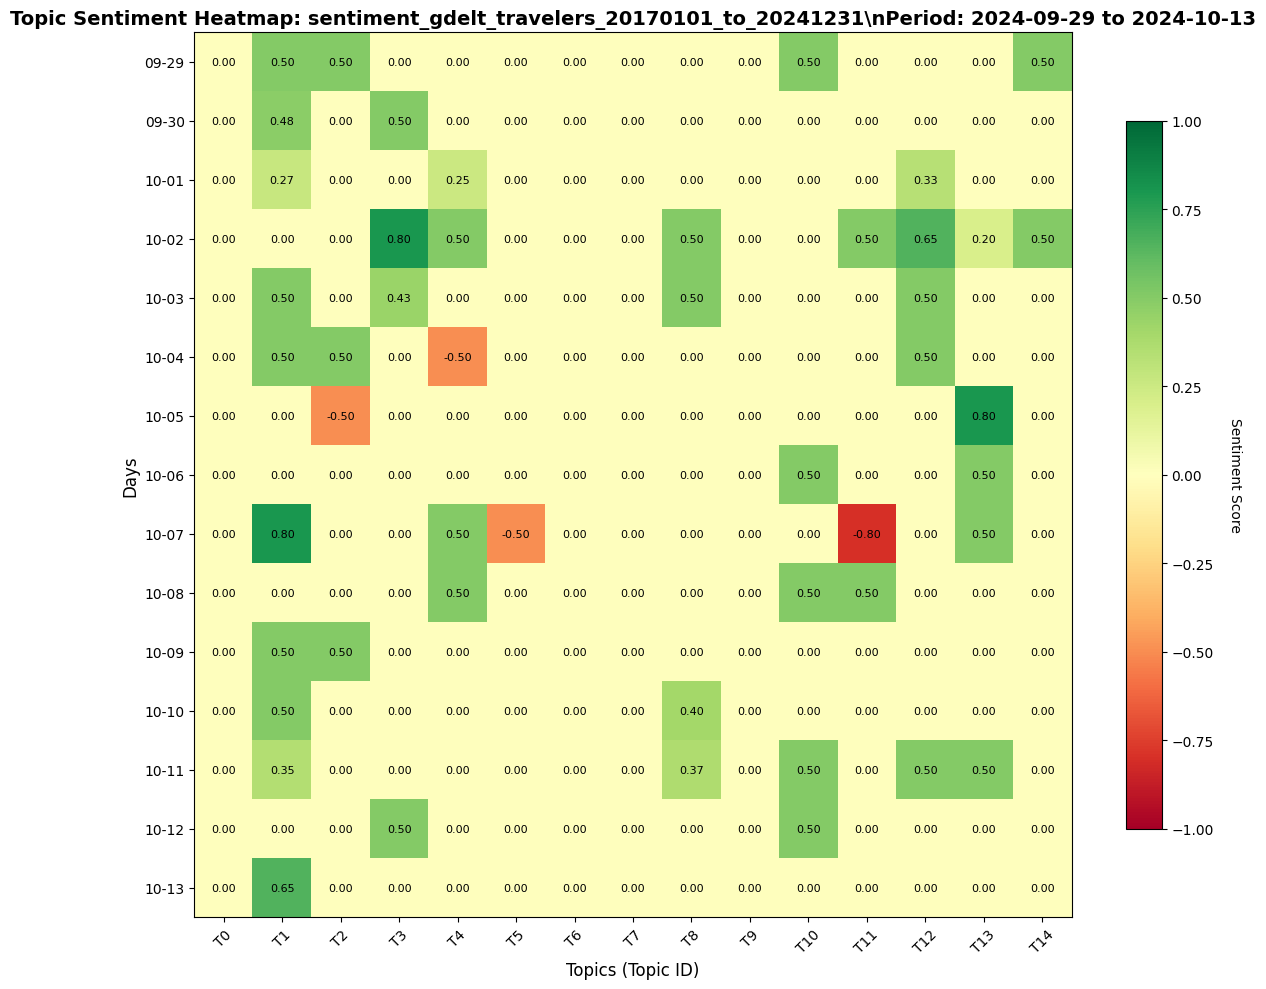

In [7]:
# Now let's create a random sentiment-topic heatmap visualization
result = analyze_random_sentiment_folder(random_seed=42)

if result:
    folder_name, fig, ax, selected_date, date_range_info = result
    
    print(f"\\nVisualization Details:")
    print(f"Company: {folder_name}")
    print(f"Selected date: {selected_date}")
    print(f"Period: {date_range_info['start_date']} to {date_range_info['end_date']}")
    print(f"Data points used: {date_range_info['data_points']}")
    print(f"Topics visualized: {date_range_info['topics_used']}")
    
    plt.show()
else:
    print("Failed to create visualization")

## Interactive Exploration

You can explore specific companies by running the cell below with different folder names.

Available sentiment folders:
 1. 3M (sentiment_gdelt_3m_20170101_to_20241231)
 2. Amazon (sentiment_gdelt_amazon_20170101_to_20241231)
 3. American (sentiment_gdelt_american_express_20170101_to_20241231)
 4. Amgen (sentiment_gdelt_amgen_20170101_to_20241231)
 5. Apple (sentiment_gdelt_apple_20170101_to_20241231)
 6. Boeing (sentiment_gdelt_boeing_20170101_to_20241231)
 7. Caterpillar (sentiment_gdelt_caterpillar_20170101_to_20241231)
 8. Chevron (sentiment_gdelt_chevron_20170101_to_20241231)
 9. Cisco (sentiment_gdelt_cisco_systems_20170101_to_20241231)
10. Disney (sentiment_gdelt_disney_20170101_to_20241231)
11. Goldman (sentiment_gdelt_goldman_sachs_20170101_to_20241231)
12. Home (sentiment_gdelt_home_depot_20170101_to_20241231)
13. Honeywell (sentiment_gdelt_honeywell_international_20170101_to_20241231)
14. Ibm (sentiment_gdelt_ibm_20170101_to_20241231)
15. Jpmorgan (sentiment_gdelt_jpmorgan_chase_20170101_to_20241231)
16. Mcdonald'S (sentiment_gdelt_mcdonald's_20170101_to_20241231)

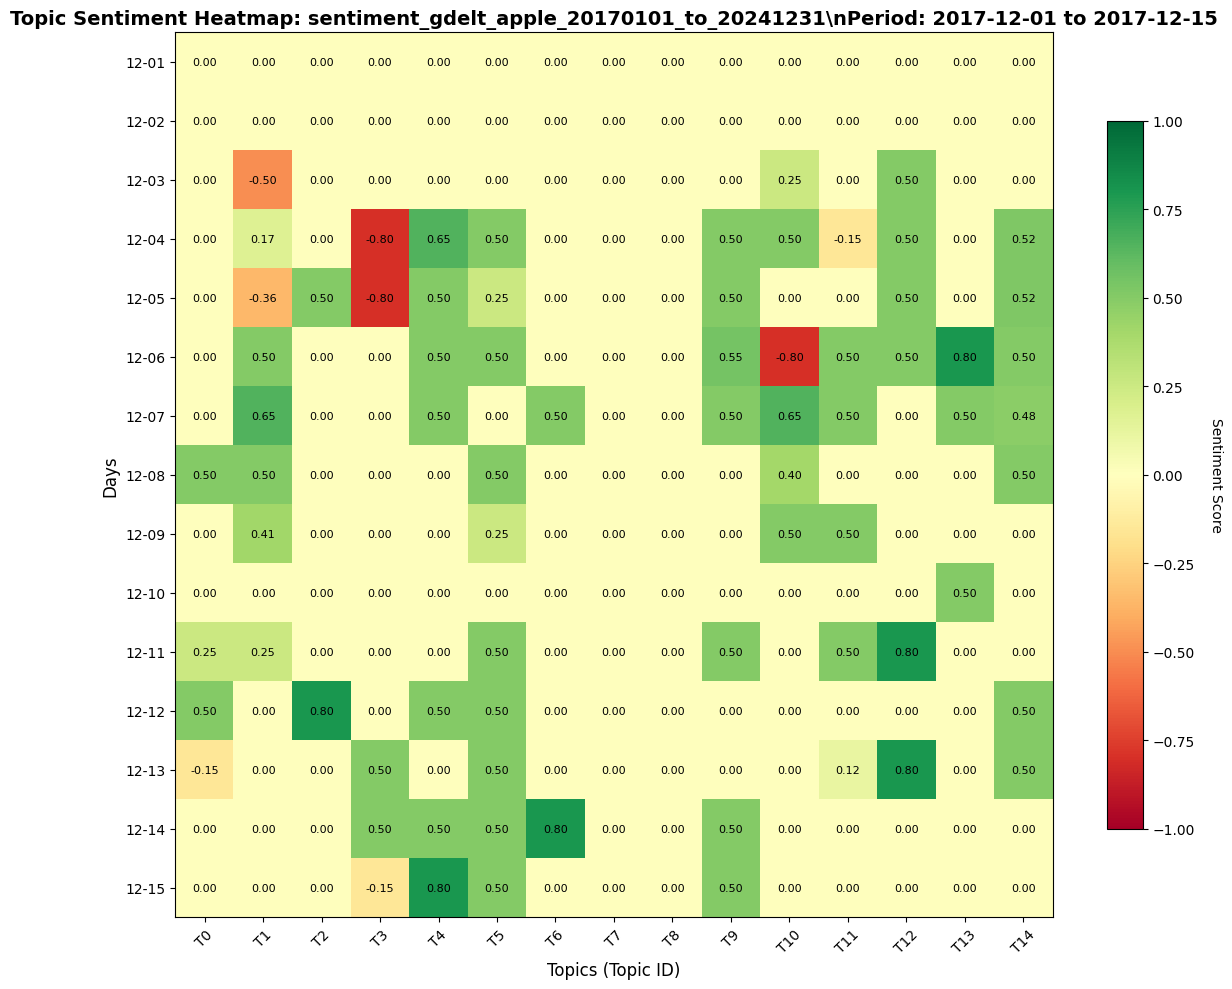

\nTopic Names:
Topic 0: Apple Music Milestone
Topic 1: Jony Ives Departure From Apple
Topic 2: Apple Watch Sales
Topic 3: Apple Vs Epic Games
Topic 4: Apples Upcoming Product Launch
Topic 5: Apple Store Closure
Topic 6: Apple Arcade Expands Game Library
Topic 7: Apple Watch Black Friday Deals
Topic 8: Apples Worldwide Developers Conference Wwdc
Topic 9: Apple Tv Update
Topic 10: Apple Maps Update
Topic 11: Apples Stock Performance
Topic 12: Apple Watch Update
Topic 13: Apple Black Friday Deals
Topic 14: Apple Pay Expansion


In [8]:
# Choose a specific company to analyze
# Available folders:
print("Available sentiment folders:")
for i, folder in enumerate(sentiment_folders, 1):
    company = folder.replace("sentiment_", "").split("_")[1]
    print(f"{i:2d}. {company.title()} ({folder})")

print("\\n" + "="*60)

# Example: Analyze Apple
target_folder = "sentiment_gdelt_apple_20170101_to_20241231"
if target_folder in sentiment_folders:
    print(f"Analyzing {target_folder}...")
    result = create_sentiment_topic_heatmap(target_folder, random_seed=123)
    
    if result:
        fig, ax, selected_date, date_range_info = result
        plt.show()
        
        # Show topic names if available
        if date_range_info['topic_names']:
            print("\\nTopic Names:")
            for topic_id in date_range_info['topics_used']:
                topic_id_str = str(topic_id)
                if topic_id_str in date_range_info['topic_names']:
                    print(f"Topic {topic_id}: {date_range_info['topic_names'][topic_id_str]}")
                else:
                    print(f"Topic {topic_id}: (No name available)")
else:
    print(f"Folder {target_folder} not found!")

## Multiple Company Comparison

Let's create visualizations for multiple companies to compare their sentiment patterns.

Creating visualizations for 3 companies...
\n============================================================
Company 1: Apple
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Selected date: 2018-12-28
Analyzing period: 2018-12-14 to 2018-12-28 (15 days)
Found 136 headlines in the period


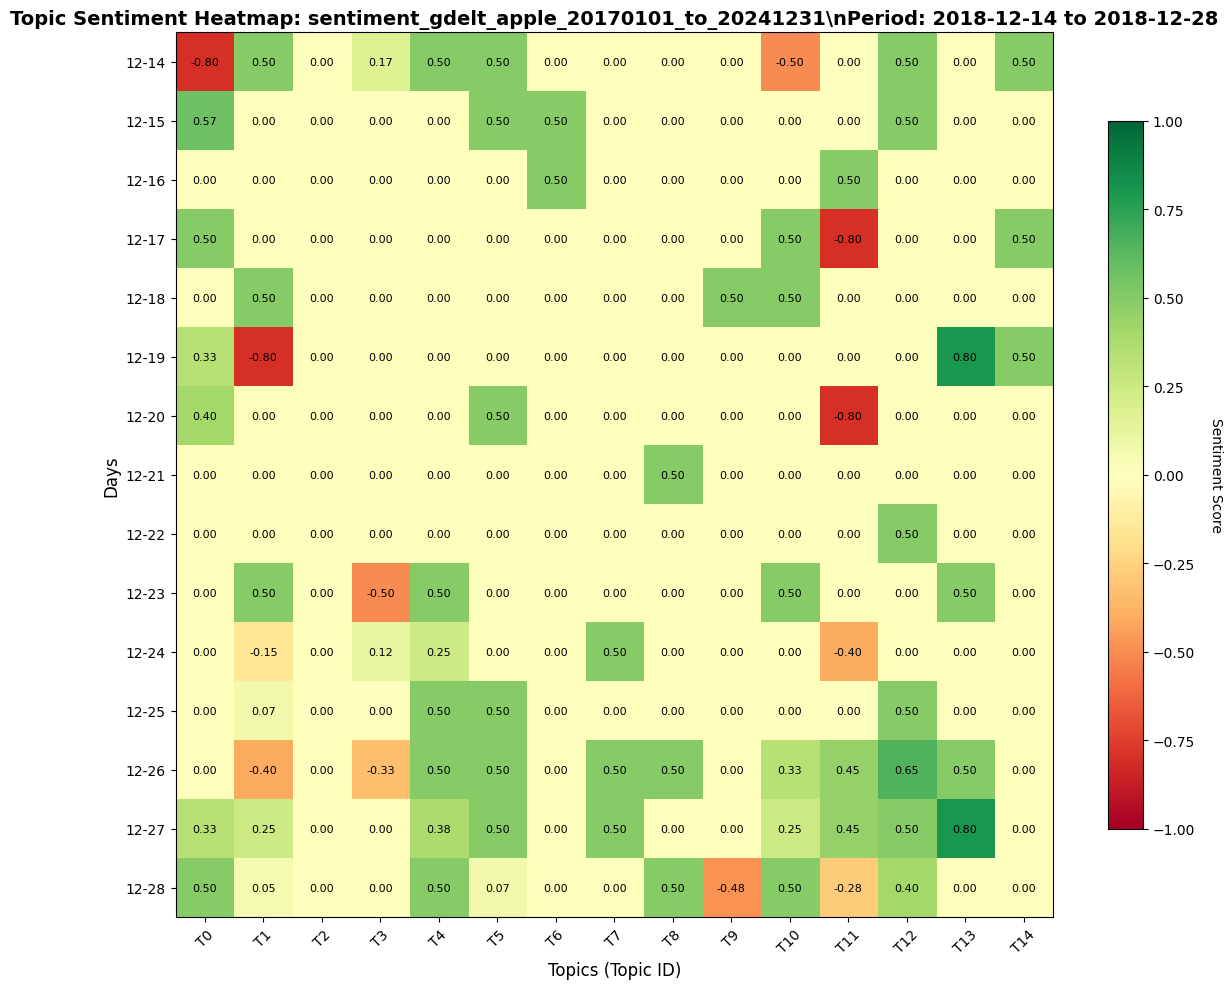

Period analyzed: 2018-12-14 to 2018-12-28
Headlines analyzed: 136
\n============================================================
Company 2: Microsoft
Loaded data for microsoft: 20689 records from 2017-01-01 05:30:00 to 2024-12-30 19:30:00
Selected date: 2017-09-29
Analyzing period: 2017-09-15 to 2017-09-29 (15 days)
Found 34 headlines in the period


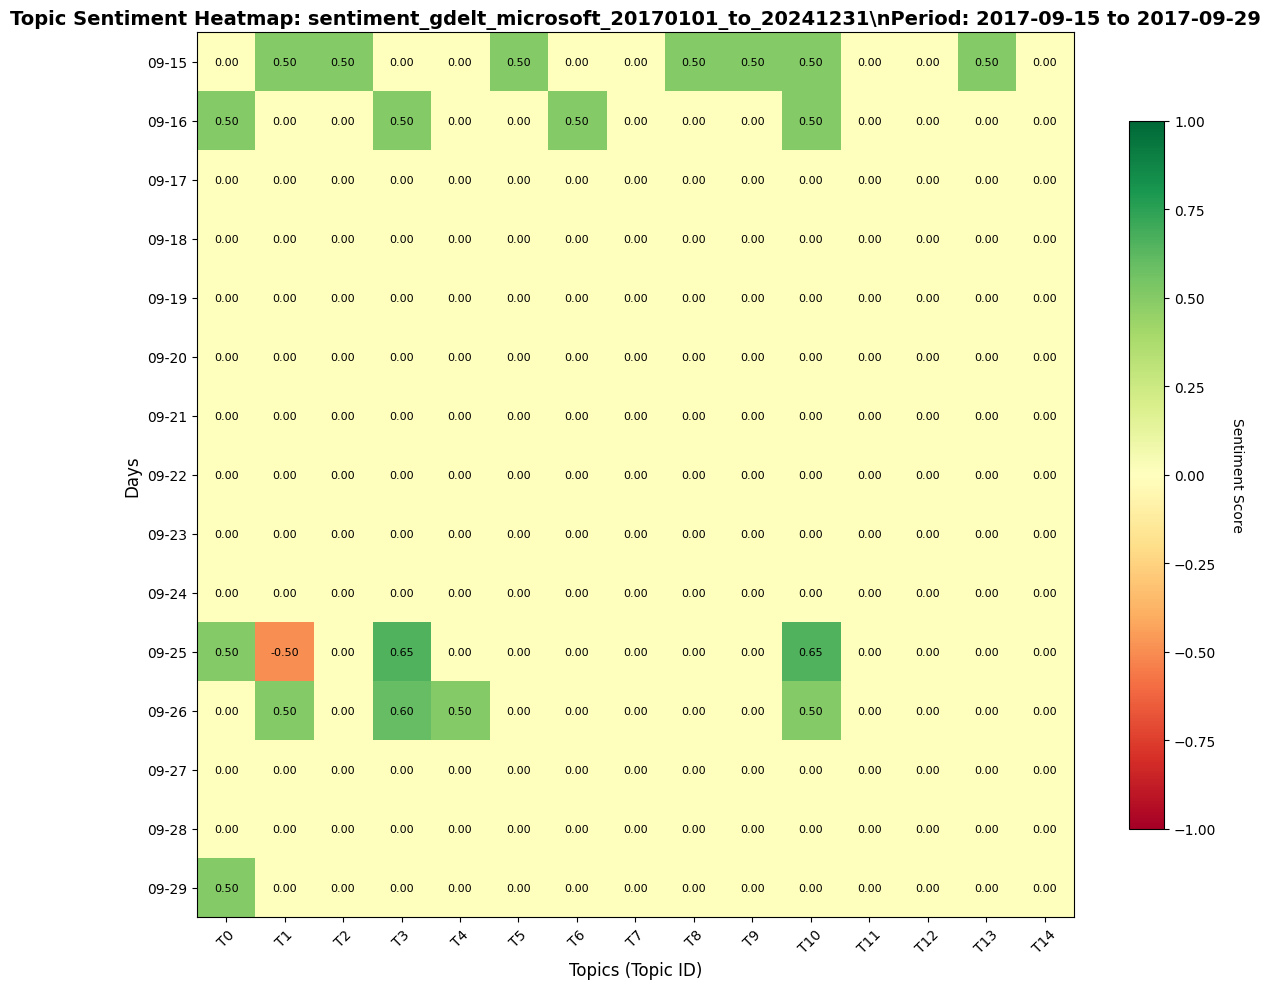

Period analyzed: 2017-09-15 to 2017-09-29
Headlines analyzed: 34
\n============================================================
Company 3: Nvidia
Loaded data for nvidia: 20536 records from 2017-01-09 13:00:00 to 2025-02-10 23:30:00
Selected date: 2022-01-05
Analyzing period: 2021-12-22 to 2022-01-05 (15 days)
Found 49 headlines in the period


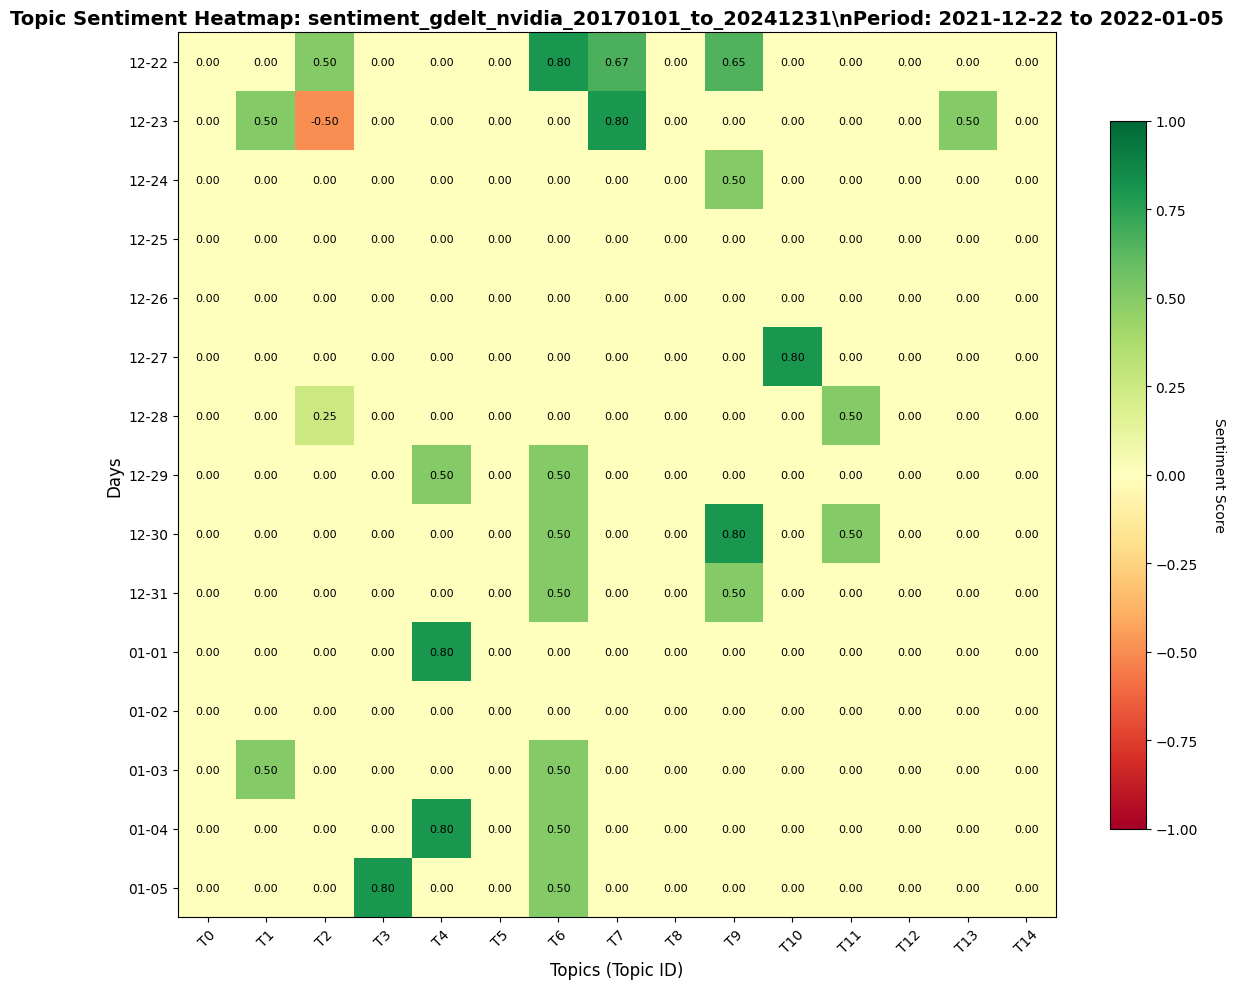

Period analyzed: 2021-12-22 to 2022-01-05
Headlines analyzed: 49
\nCompleted analysis of 3 companies.


In [9]:
# Create visualizations for multiple companies
companies_to_analyze = [
    "sentiment_gdelt_apple_20170101_to_20241231",
    "sentiment_gdelt_microsoft_20170101_to_20241231", 
    "sentiment_gdelt_nvidia_20170101_to_20241231"
]

# Filter to only existing folders
available_companies = [folder for folder in companies_to_analyze if folder in sentiment_folders]

print(f"Creating visualizations for {len(available_companies)} companies...")

for i, folder in enumerate(available_companies):
    print(f"\\n{'='*60}")
    company_name = folder.replace("sentiment_", "").split("_")[1].title()
    print(f"Company {i+1}: {company_name}")
    print('='*60)
    
    result = create_sentiment_topic_heatmap(folder, random_seed=42+i)
    
    if result:
        fig, ax, selected_date, date_range_info = result
        plt.show()
        
        print(f"Period analyzed: {date_range_info['start_date']} to {date_range_info['end_date']}")
        print(f"Headlines analyzed: {date_range_info['data_points']}")
    else:
        print(f"Failed to create visualization for {company_name}")

print(f"\\nCompleted analysis of {len(available_companies)} companies.")

In [10]:
def debug_data_loading(folder_name):
    """
    Debug function to investigate data loading issues.
    """
    print(f"Debugging data loading for: {folder_name}")
    print("="*60)
    
    try:
        # Extract company name from folder name
        company_name = folder_name.replace("sentiment_", "").split("_")[1]
        
        # Paths
        sentiment_folder_path = os.path.join(CLEANED_DATA_PATH, folder_name)
        original_data_path = os.path.join(CLEANED_DATA_PATH, f"gdelt_{company_name}.csv")
        
        print(f"Company: {company_name}")
        print(f"Original data path: {original_data_path}")
        print(f"Sentiment folder path: {sentiment_folder_path}")
        
        # Load and check each file separately
        print("\n1. Loading original data...")
        original_df = pd.read_csv(original_data_path)
        print(f"   Original data shape: {original_df.shape}")
        print(f"   Original columns: {list(original_df.columns)}")
        print(f"   Sample headlines from original:")
        for i, headline in enumerate(original_df['Headline'].head(3)):
            print(f"      {i+1}. {headline[:100]}...")
        
        print("\n2. Loading topics data...")
        topics_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_topics.csv"))
        print(f"   Topics data shape: {topics_df.shape}")
        print(f"   Topics columns: {list(topics_df.columns)}")
        print(f"   Sample headlines from topics:")
        for i, headline in enumerate(topics_df['headline'].head(3)):
            print(f"      {i+1}. {headline[:100]}...")
        
        print("\n3. Loading sentiments data...")
        sentiments_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_sentiments.csv"))
        print(f"   Sentiments data shape: {sentiments_df.shape}")
        print(f"   Sentiments columns: {list(sentiments_df.columns)}")
        
        print("\n4. Checking headline matching...")
        # Check exact matches
        original_headlines = set(original_df['Headline'].str.strip().str.lower())
        topic_headlines = set(topics_df['headline'].str.strip().str.lower())
        sentiment_headlines = set(sentiments_df['headline'].str.strip().str.lower())
        
        print(f"   Original headlines (unique): {len(original_headlines)}")
        print(f"   Topic headlines (unique): {len(topic_headlines)}")
        print(f"   Sentiment headlines (unique): {len(sentiment_headlines)}")
        
        # Find intersections
        orig_topic_match = original_headlines & topic_headlines
        orig_sentiment_match = original_headlines & sentiment_headlines
        topic_sentiment_match = topic_headlines & sentiment_headlines
        all_three_match = original_headlines & topic_headlines & sentiment_headlines
        
        print(f"   Original ∩ Topics: {len(orig_topic_match)}")
        print(f"   Original ∩ Sentiments: {len(orig_sentiment_match)}")
        print(f"   Topics ∩ Sentiments: {len(topic_sentiment_match)}")
        print(f"   All three match: {len(all_three_match)}")
        
        print("\n5. Trying the merge...")
        # Try merge step by step
        merged1 = original_df.merge(topics_df, left_on='Headline', right_on='headline', how='inner')
        print(f"   After merging original + topics: {merged1.shape}")
        
        merged2 = merged1.merge(sentiments_df, left_on='Headline', right_on='headline', how='inner')
        print(f"   After merging with sentiments: {merged2.shape}")
        
        # Check for potential issues
        print("\n6. Potential issues:")
        
        # Check for case sensitivity
        orig_exact = set(original_df['Headline'])
        topic_exact = set(topics_df['headline'])
        
        case_sensitive_match = orig_exact & topic_exact
        print(f"   Case-sensitive exact matches: {len(case_sensitive_match)}")
        
        # Check for whitespace issues
        orig_clean = set(original_df['Headline'].str.strip())
        topic_clean = set(topics_df['headline'].str.strip())
        
        whitespace_clean_match = orig_clean & topic_clean
        print(f"   After whitespace cleaning: {len(whitespace_clean_match)}")
        
        return merged2
        
    except Exception as e:
        print(f"Error in debug function: {str(e)}")
        return None

# Test with the 3m folder
test_folder = "sentiment_gdelt_3m_20170101_to_20241231"
debug_result = debug_data_loading(test_folder)

Debugging data loading for: sentiment_gdelt_3m_20170101_to_20241231
Company: 3m
Original data path: C:\Users\KemalUtkuLekesiz\Documents\Kod\Okul\NLP\SentimTA\data_sentim\cleaned\gdelt_3m.csv
Sentiment folder path: C:\Users\KemalUtkuLekesiz\Documents\Kod\Okul\NLP\SentimTA\data_sentim\cleaned\sentiment_gdelt_3m_20170101_to_20241231

1. Loading original data...
   Original data shape: (19428, 4)
   Original columns: ['URL', 'MobileURL', 'Date', 'Headline']
   Sample headlines from original:
      1. 3M Announces Upcoming Investor Events...
      2. 3M Wins Preliminary Injunction Against Spain...
      3. Statement from 3M on the Passing of Livio D .  Desi  DeSimone , Former Chairman and Chief Executive ...

2. Loading topics data...
   Topics data shape: (18317, 2)
   Topics columns: ['headline', 'topic_id']
   Sample headlines from topics:
      1. 3m announces upcoming investor events...
      2. 3m wins preliminary injunction against spain...
      3. statement from 3m on the passing o

In [11]:
# Quick check of data sizes
def quick_data_check(folder_name):
    company_name = folder_name.replace("sentiment_", "").split("_")[1]
    sentiment_folder_path = os.path.join(CLEANED_DATA_PATH, folder_name)
    original_data_path = os.path.join(CLEANED_DATA_PATH, f"gdelt_{company_name}.csv")
    
    # Load data
    original_df = pd.read_csv(original_data_path)
    topics_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_topics.csv"))
    sentiments_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_sentiments.csv"))
    
    print(f"Company: {company_name}")
    print(f"Original data: {len(original_df)} rows")
    print(f"Topics data: {len(topics_df)} rows")
    print(f"Sentiments data: {len(sentiments_df)} rows")
    
    # Check merge results
    merged1 = original_df.merge(topics_df, left_on='Headline', right_on='headline', how='inner')
    merged2 = merged1.merge(sentiments_df, left_on='Headline', right_on='headline', how='inner')
    
    print(f"After merging: {len(merged2)} rows")
    print(f"Loss rate: {(len(original_df) - len(merged2)) / len(original_df) * 100:.1f}%")
    
    return len(original_df), len(merged2)

# Test with 3m
original_count, merged_count = quick_data_check("sentiment_gdelt_3m_20170101_to_20241231")

Company: 3m
Original data: 19428 rows
Topics data: 18317 rows
Sentiments data: 18317 rows
After merging: 64 rows
Loss rate: 99.7%


In [12]:
# Check sample headlines to see differences
def compare_headlines(folder_name, n_samples=5):
    company_name = folder_name.replace("sentiment_", "").split("_")[1]
    sentiment_folder_path = os.path.join(CLEANED_DATA_PATH, folder_name)
    original_data_path = os.path.join(CLEANED_DATA_PATH, f"gdelt_{company_name}.csv")
    
    original_df = pd.read_csv(original_data_path)
    topics_df = pd.read_csv(os.path.join(sentiment_folder_path, "headline_topics.csv"))
    
    print("ORIGINAL HEADLINES (first 5):")
    for i, headline in enumerate(original_df['Headline'].head(n_samples)):
        print(f"{i+1:2d}. '{headline}'")
    
    print("\nTOPICS HEADLINES (first 5):")
    for i, headline in enumerate(topics_df['headline'].head(n_samples)):
        print(f"{i+1:2d}. '{headline}'")
    
    print("\nCHECKING IF ANY EXACT MATCHES EXIST...")
    original_set = set(original_df['Headline'])
    topics_set = set(topics_df['headline'])
    exact_matches = original_set & topics_set
    print(f"Exact matches found: {len(exact_matches)}")
    
    if len(exact_matches) > 0:
        print("Sample exact matches:")
        for i, match in enumerate(list(exact_matches)[:3]):
            print(f"  {i+1}. '{match}'")

compare_headlines("sentiment_gdelt_3m_20170101_to_20241231")

ORIGINAL HEADLINES (first 5):
 1. '3M Announces Upcoming Investor Events'
 2. '3M Wins Preliminary Injunction Against Spain'
 3. 'Statement from 3M on the Passing of Livio D .  Desi  DeSimone , Former Chairman and Chief Executive Officer '
 4. 'Statement from 3M on the Passing of Livio D .  Desi  DeSimone , Former Chairman and Chief Executive Officer'
 5. 'Former 3M CEO Desi DeSimone dies'

TOPICS HEADLINES (first 5):
 1. '3m announces upcoming investor events'
 2. '3m wins preliminary injunction against spain'
 3. 'statement from 3m on the passing of livio d .  desi  desimone , former chairman and chief executive officer'
 4. 'statement from 3m on the passing of livio d .  desi  desimone , former chairman and chief executive officer'
 5. 'former 3m ceo desi desimone dies'

CHECKING IF ANY EXACT MATCHES EXIST...
Exact matches found: 52
Sample exact matches:
  1. 'why doesnt it run ?'
  2. '10 single - pass cultivator options for heavy land'
  3. 'wbir . com'


In [13]:
# Test the fixed data loading function
print("Testing fixed data loading function...")
test_df, test_topic_names = load_data_for_folder("sentiment_gdelt_3m_20170101_to_20241231")

if test_df is not None:
    print(f"SUCCESS! Now we have {len(test_df)} records instead of just 64!")
    print(f"Data coverage: {len(test_df)} out of ~19,428 original records")
    print(f"Coverage rate: {len(test_df) / 19428 * 100:.1f}%")
else:
    print("Still having issues with data loading...")

Testing fixed data loading function...
Loaded data for 3m: 19599 records from 2017-01-01 05:45:00 to 2025-04-02 06:15:00
SUCCESS! Now we have 19599 records instead of just 64!
Data coverage: 19599 out of ~19,428 original records
Coverage rate: 100.9%


Testing visualization with fixed data loading...
Loaded data for 3m: 19599 records from 2017-01-01 05:45:00 to 2025-04-02 06:15:00
Selected date: 2024-06-05
Analyzing period: 2024-05-22 to 2024-06-05 (15 days)
Found 113 headlines in the period
Success! Using 113 data points


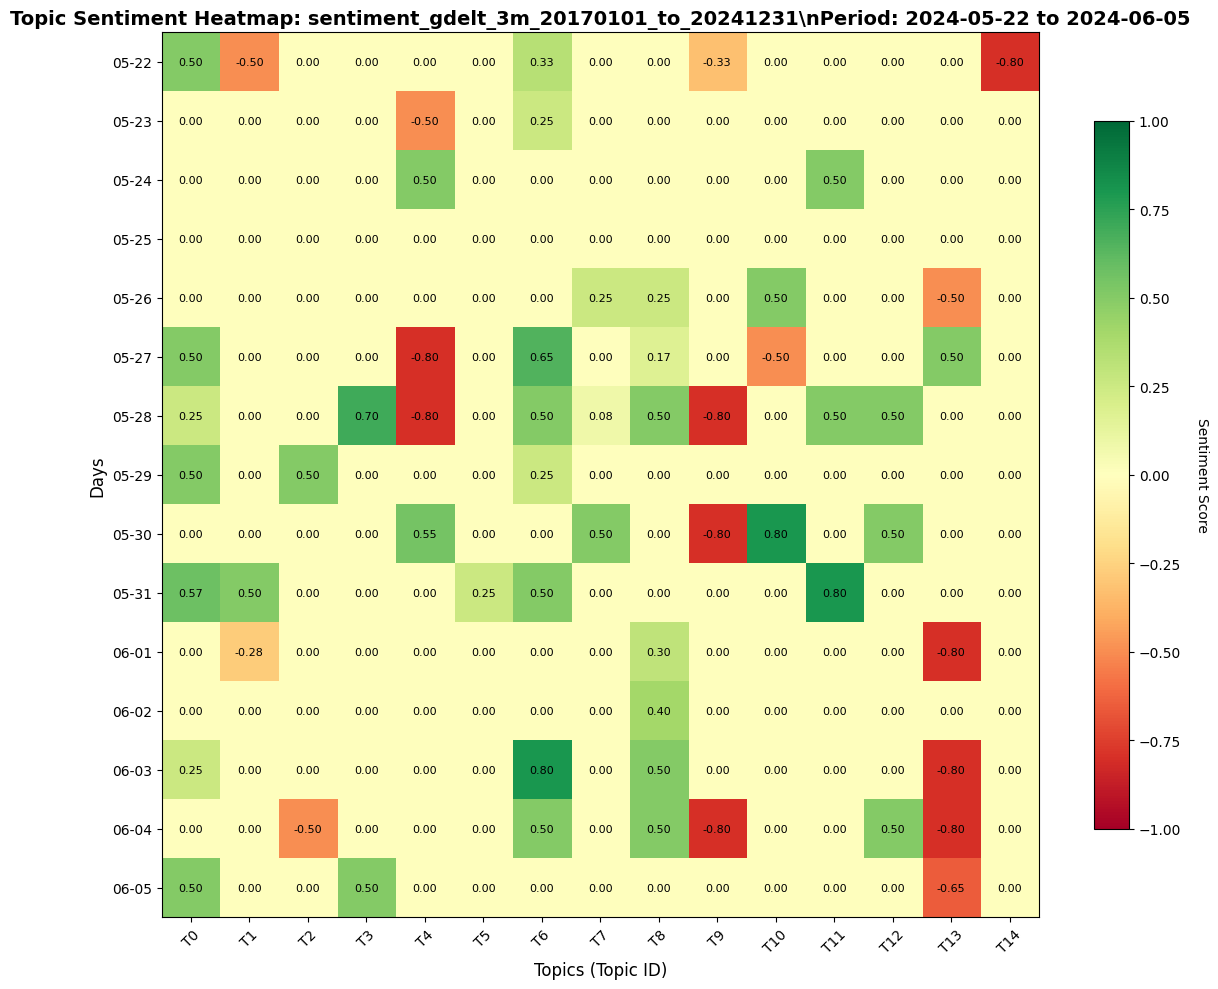

In [14]:
# Test visualization with much more data
print("Testing visualization with fixed data loading...")
result = create_sentiment_topic_heatmap("sentiment_gdelt_3m_20170101_to_20241231", random_seed=42)

if result:
    fig, ax, selected_date, date_range_info = result
    print(f"Success! Using {date_range_info['data_points']} data points")
    plt.show()
else:
    print("Visualization failed")

## Flipped Axes Visualization and Topic Correlation Analysis

Now let's test the updated visualization with flipped axes (days on x-axis) and analyze correlations between topics.

Testing flipped axes visualization (days on x-axis)...
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Selected date: 2018-12-28
Analyzing period: 2018-12-14 to 2018-12-28 (15 days)
Found 136 headlines in the period
Success! Visualization shows:
  X-axis: Days (2018-12-14 to 2018-12-28)
  Y-axis: Topics (15 topics)
  Data points: 136


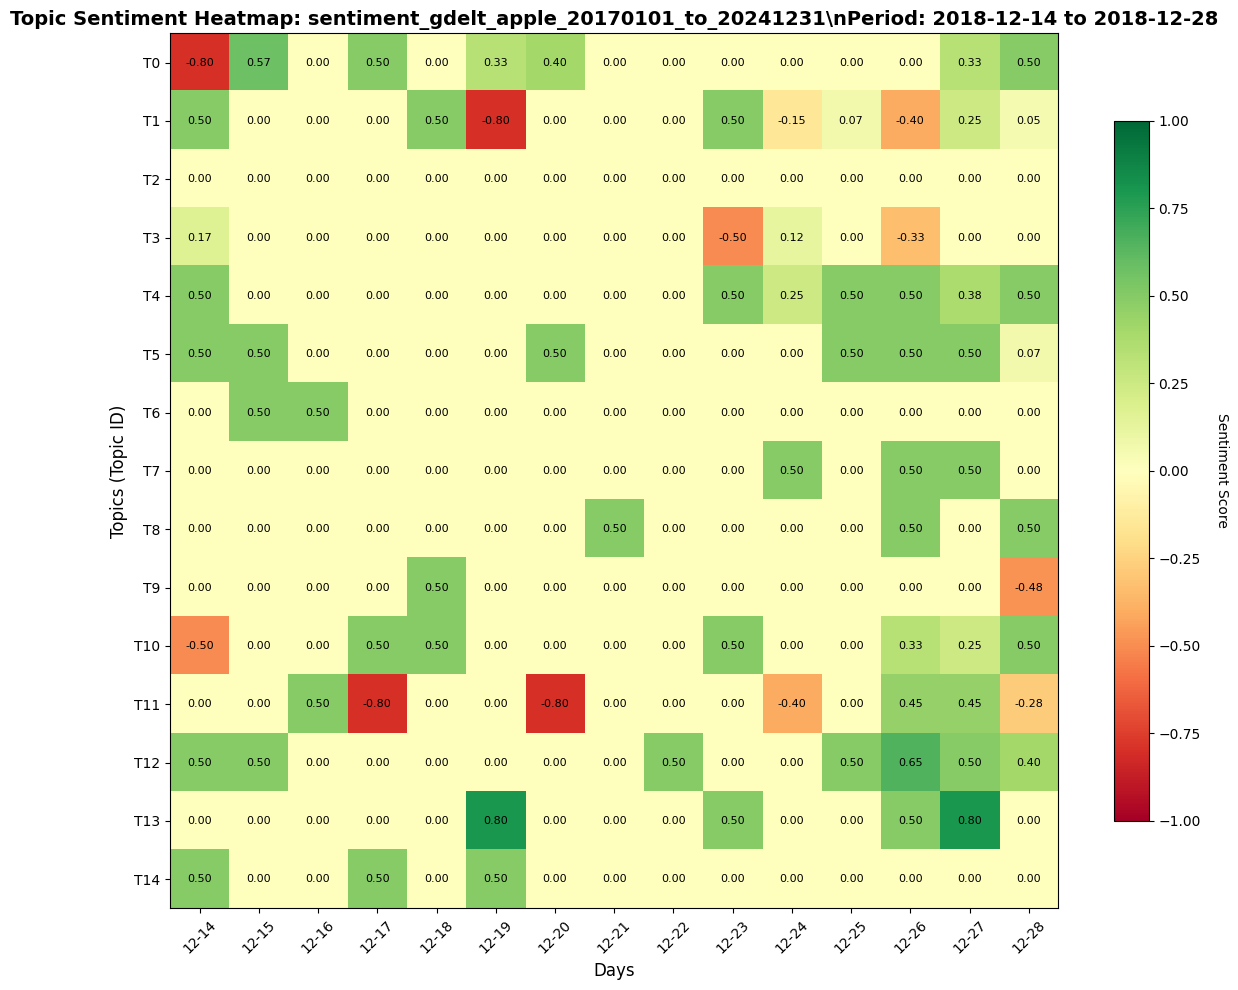

In [17]:
# Test the flipped axes visualization
print("Testing flipped axes visualization (days on x-axis)...")
result = create_sentiment_topic_heatmap("sentiment_gdelt_apple_20170101_to_20241231", random_seed=42)

if result:
    fig, ax, selected_date, date_range_info = result
    print(f"Success! Visualization shows:")
    print(f"  X-axis: Days ({date_range_info['start_date']} to {date_range_info['end_date']})")
    print(f"  Y-axis: Topics ({len(date_range_info['topics_used'])} topics)")
    print(f"  Data points: {date_range_info['data_points']}")
    plt.show()
else:
    print("Visualization failed")

\nAnalyzing topic correlations...
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Selected date: 2018-12-28
Analyzing period: 2018-12-14 to 2018-12-28 (15 days)
Found 136 headlines in the period
\nTopic Correlation Analysis for sentiment_gdelt_apple_20170101_to_20241231
Topics with varying sentiment: 14 out of 15
Excluded topics (constant sentiment): [2]
\nFound 0 highly correlated topic pairs (|r| > 0.7):
  No highly correlated topic pairs found.
\nOverall Correlation Statistics:
  Mean correlation: -0.002
  Std correlation: 0.253
  Max correlation: 0.671
  Min correlation: -0.559


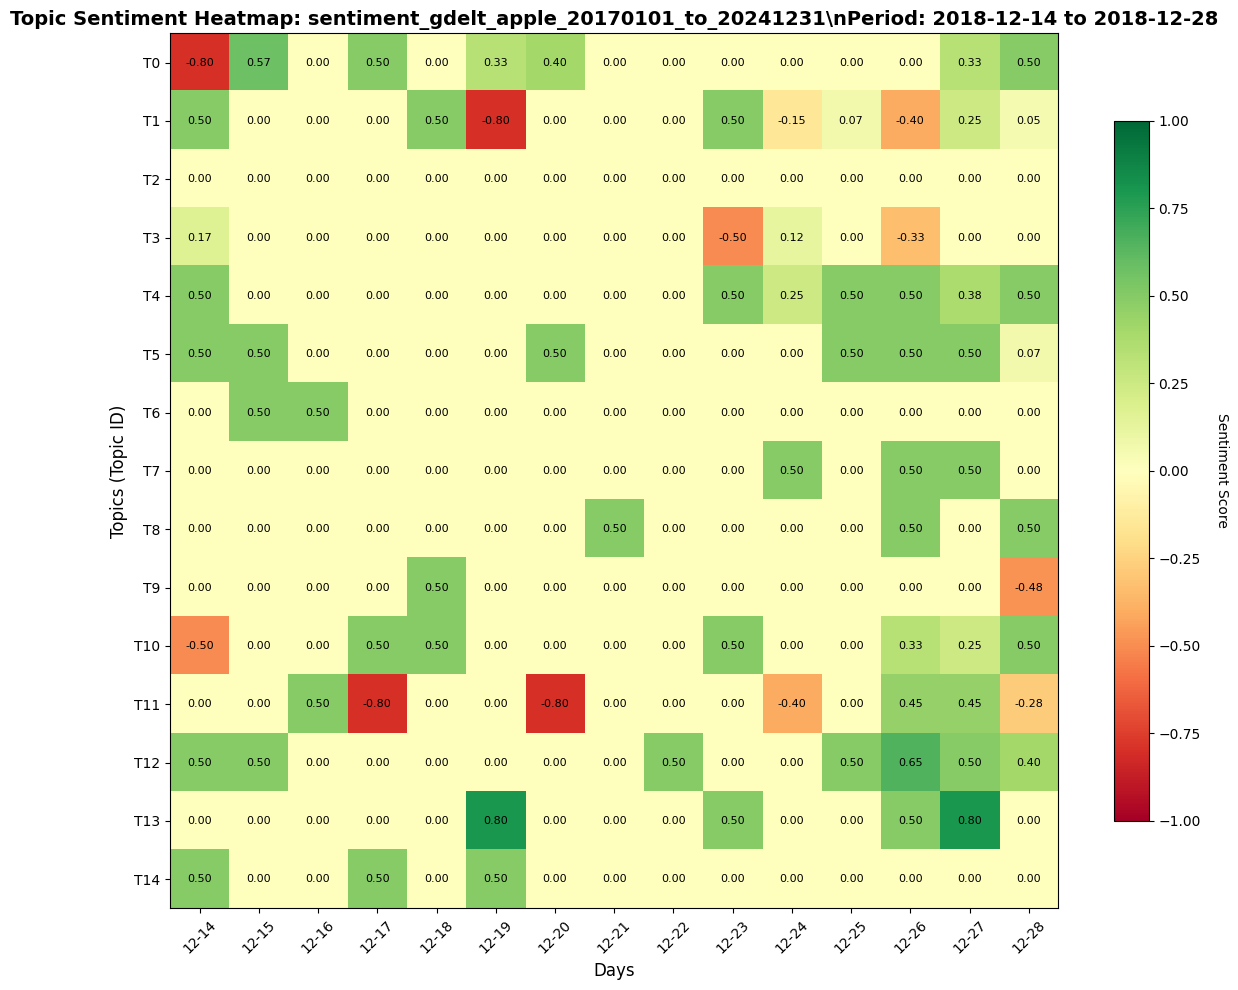

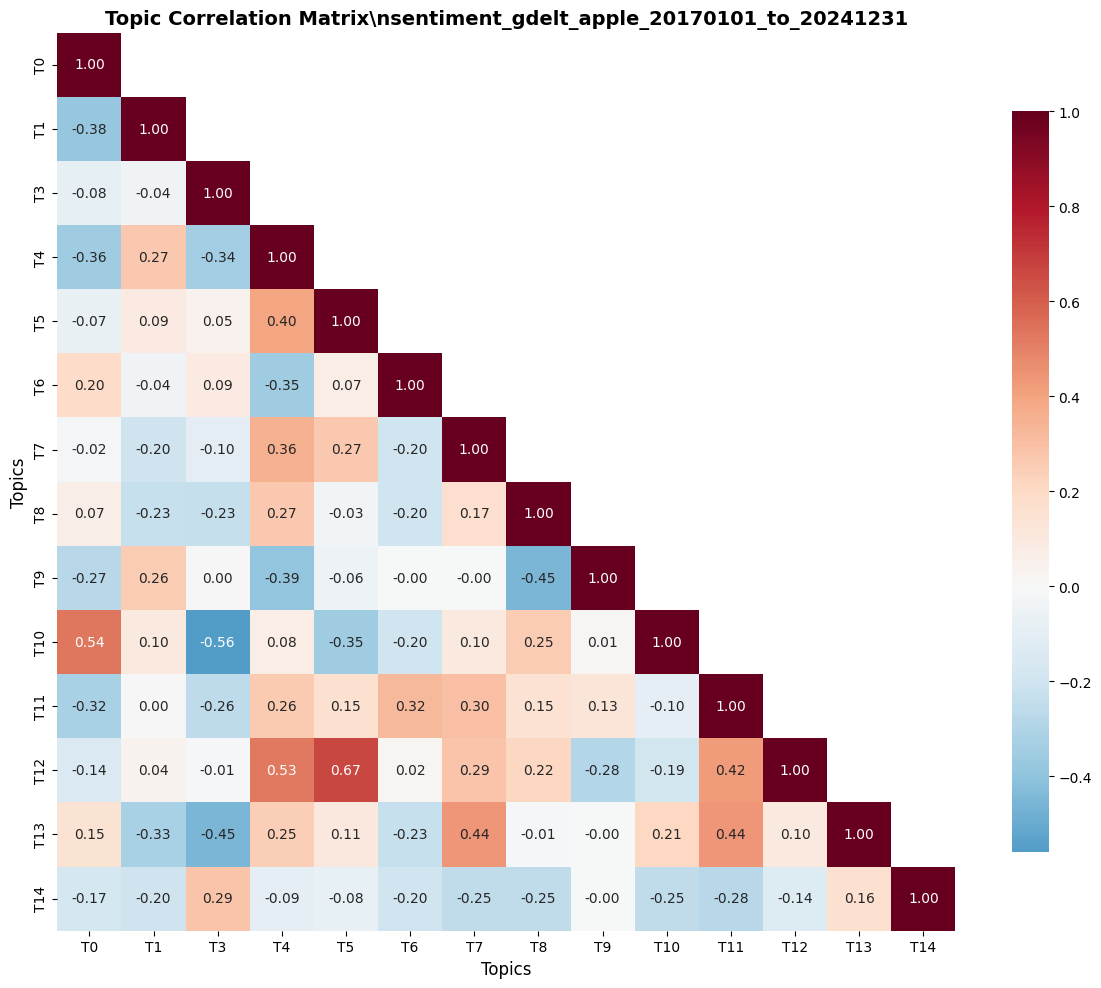

In [20]:
# Test the correlation analysis
print("\\nAnalyzing topic correlations...")
correlation_matrix, correlations_info, sentiment_matrix = analyze_topic_correlations(
    "sentiment_gdelt_apple_20170101_to_20241231", 
    random_seed=42, 
    show_heatmap=True
)

## Comparative Analysis Across Companies

Let's compare the topic correlations and sentiment patterns across different companies.

Comparative Analysis for 3 companies:
\n1. Apple
------------------------------------------------------------
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Selected date: 2018-12-28
Analyzing period: 2018-12-14 to 2018-12-28 (15 days)
Found 136 headlines in the period


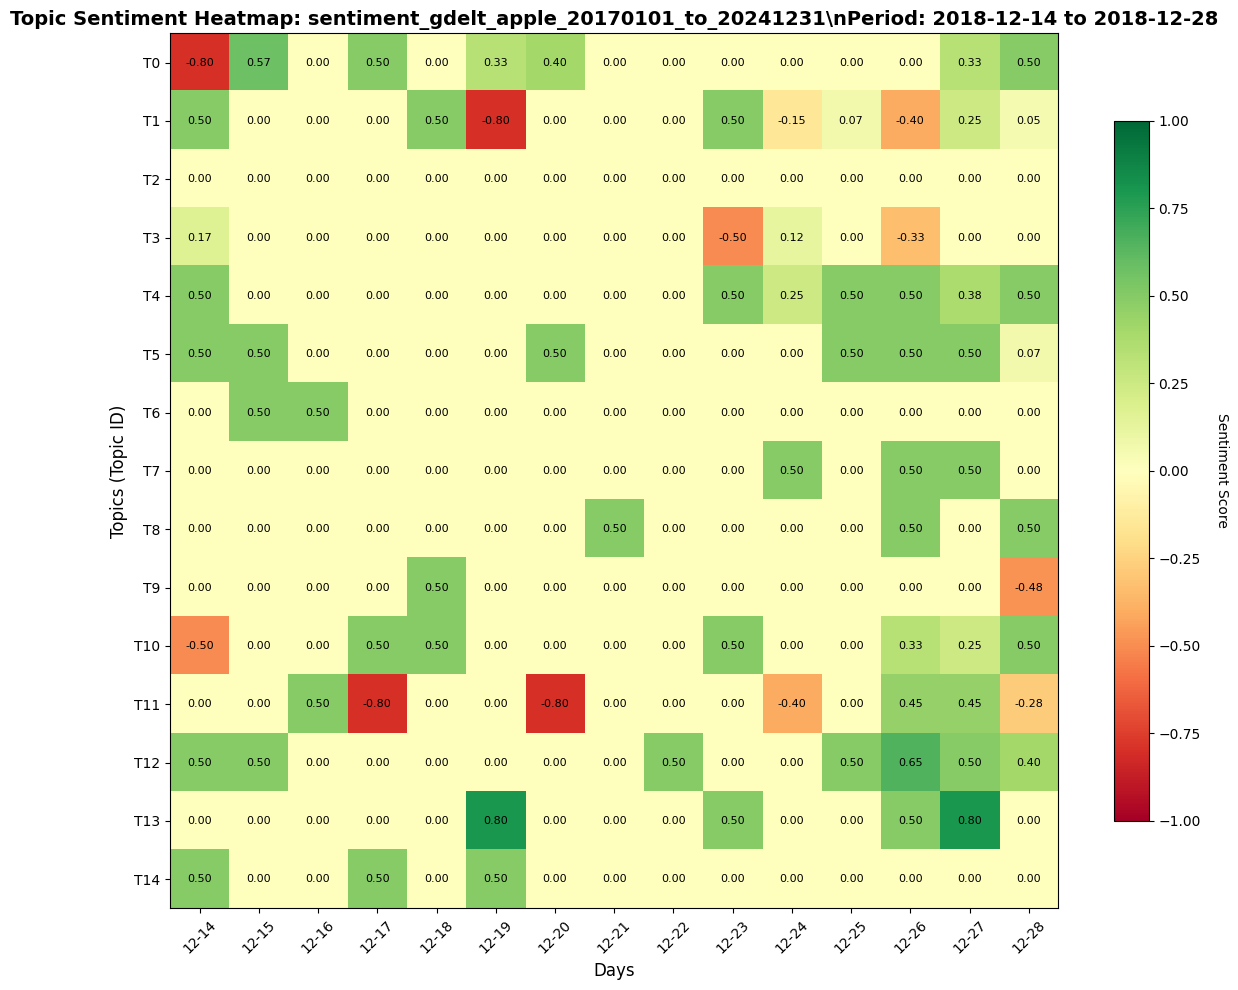

Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Selected date: 2018-12-28
Analyzing period: 2018-12-14 to 2018-12-28 (15 days)
Found 136 headlines in the period
\nTopic Correlation Analysis for sentiment_gdelt_apple_20170101_to_20241231
Topics with varying sentiment: 14 out of 15
Excluded topics (constant sentiment): [2]
\nFound 0 highly correlated topic pairs (|r| > 0.7):
  No highly correlated topic pairs found.
\nOverall Correlation Statistics:
  Mean correlation: -0.002
  Std correlation: 0.253
  Max correlation: 0.671
  Min correlation: -0.559
Correlation Summary for Apple:
  • Topics analyzed: 14
  • Excluded topics: [2]
  • Mean correlation: -0.002
  • Max correlation: 0.671
  • High correlations (|r|>0.7): 0
\n2. Microsoft
------------------------------------------------------------
Loaded data for microsoft: 20689 records from 2017-01-01 05:30:00 to 2024-12-30 19:30:00
Selected date: 2017-09-29
Analyzing period: 2017-09-15 to 2017-09-29 (15

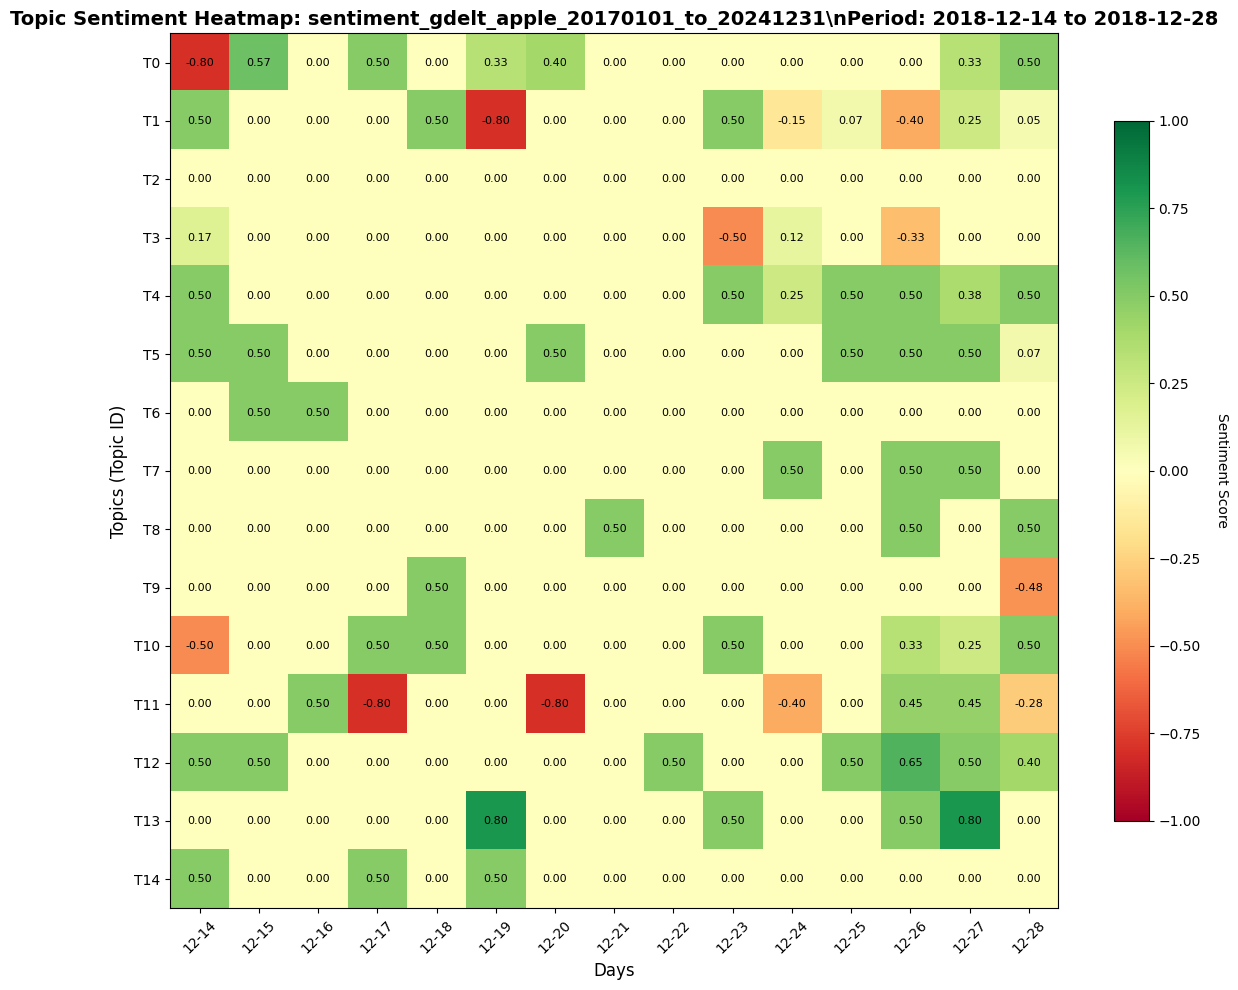

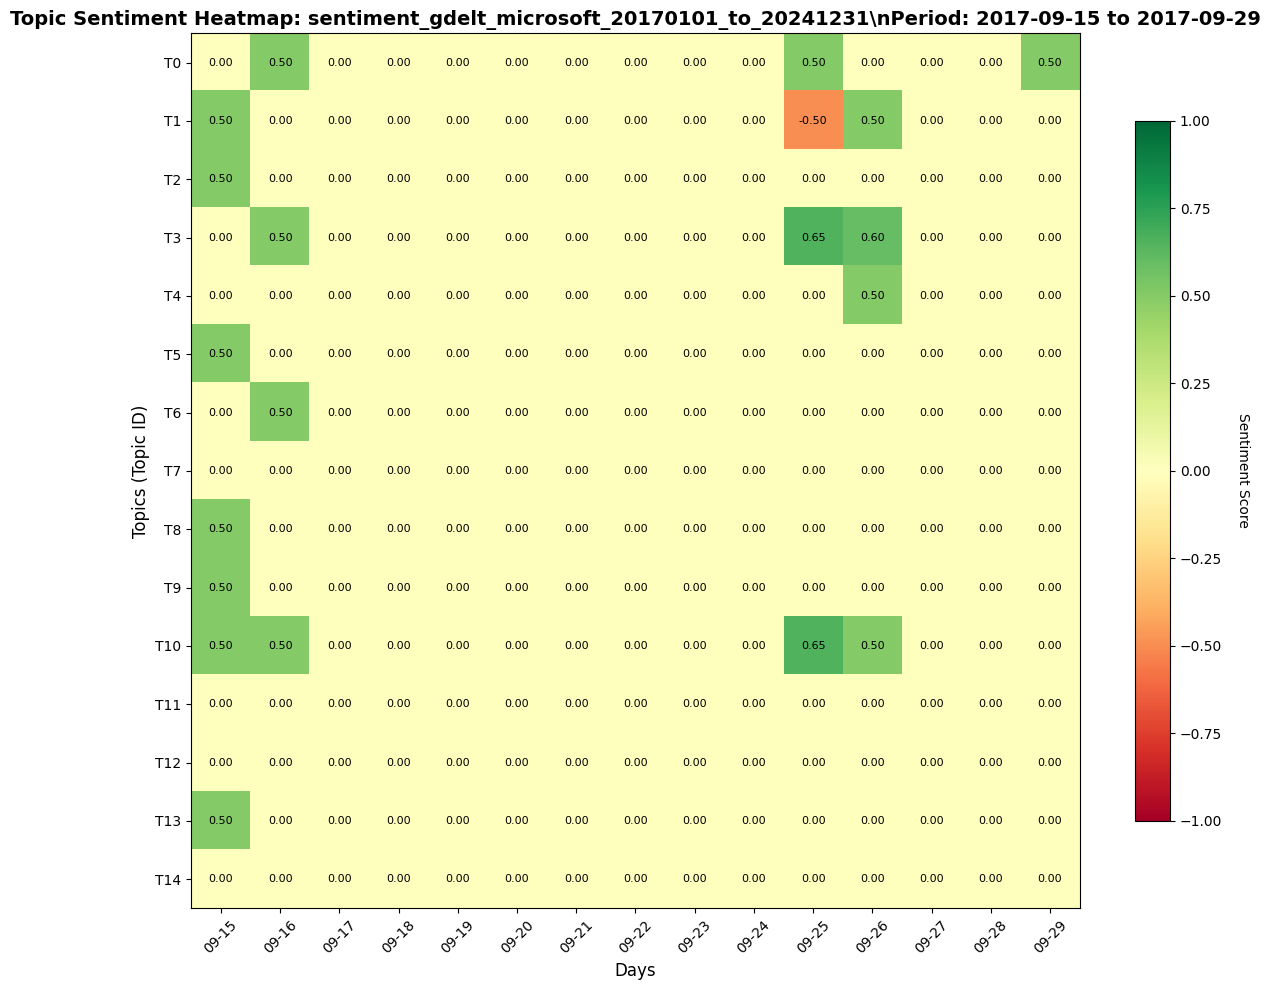

Loaded data for microsoft: 20689 records from 2017-01-01 05:30:00 to 2024-12-30 19:30:00
Selected date: 2017-09-29
Analyzing period: 2017-09-15 to 2017-09-29 (15 days)
Found 34 headlines in the period
\nTopic Correlation Analysis for sentiment_gdelt_microsoft_20170101_to_20241231
Topics with varying sentiment: 11 out of 15
Excluded topics (constant sentiment): [7, 11, 12, 14]
\nFound 11 highly correlated topic pairs (|r| > 0.7):
  T2 ↔ T5: r = 1.000 (positive)
    Microsofts Deal With The Us Army ↔ Microsoft Layoffs

  T2 ↔ T8: r = 1.000 (positive)
    Microsofts Deal With The Us Army ↔ Microsofts Stock Performance

  T2 ↔ T9: r = 1.000 (positive)
    Microsofts Deal With The Us Army ↔ Microsoft Data Breach

  T2 ↔ T13: r = 1.000 (positive)
    Microsofts Deal With The Us Army ↔ Microsoft Edge Update

  T5 ↔ T8: r = 1.000 (positive)
    Microsoft Layoffs ↔ Microsofts Stock Performance

  T5 ↔ T9: r = 1.000 (positive)
    Microsoft Layoffs ↔ Microsoft Data Breach

  T5 ↔ T13: r = 1.000 

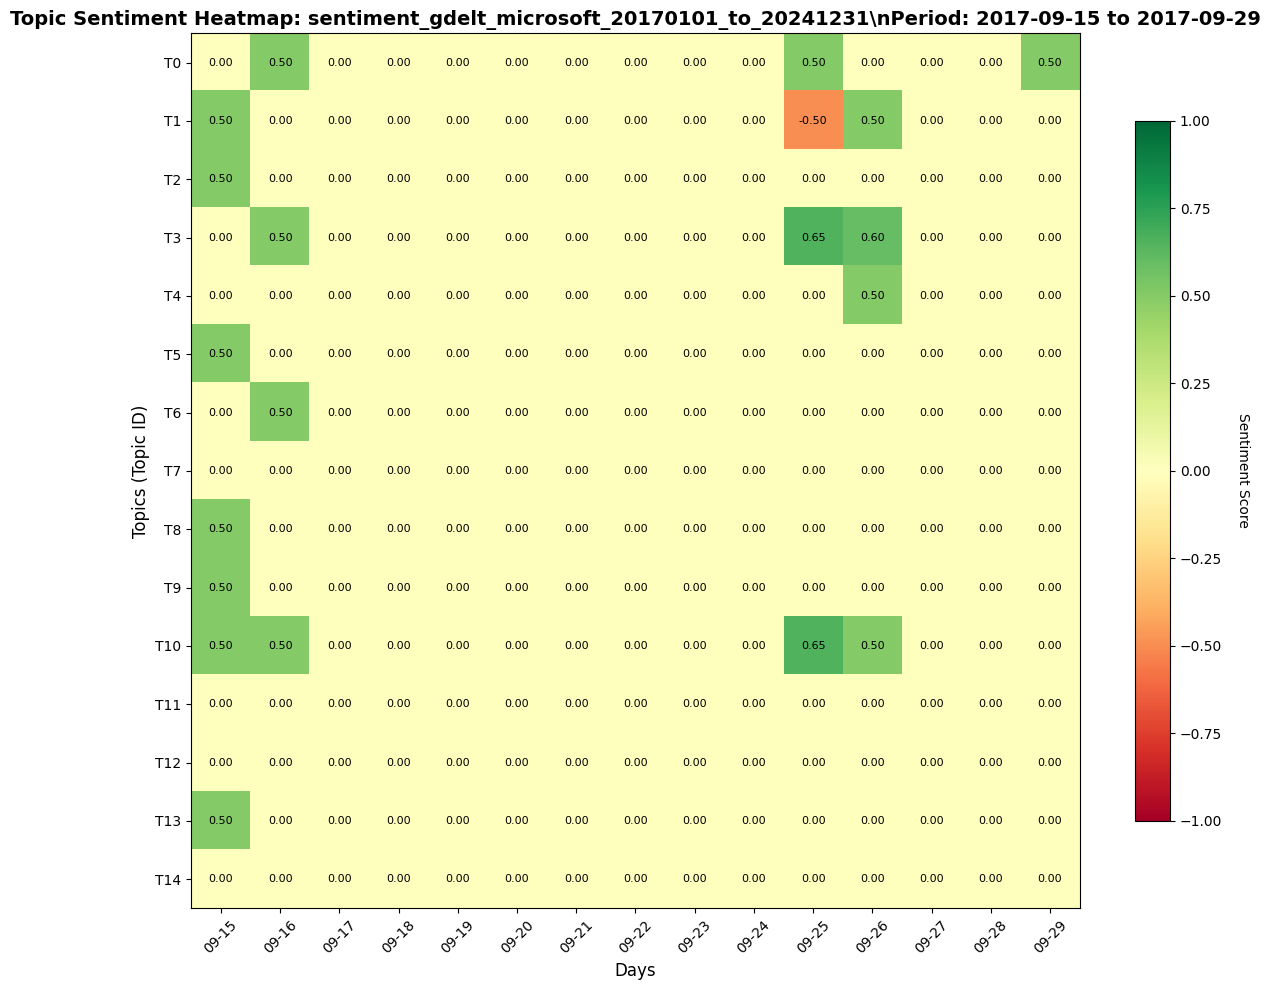

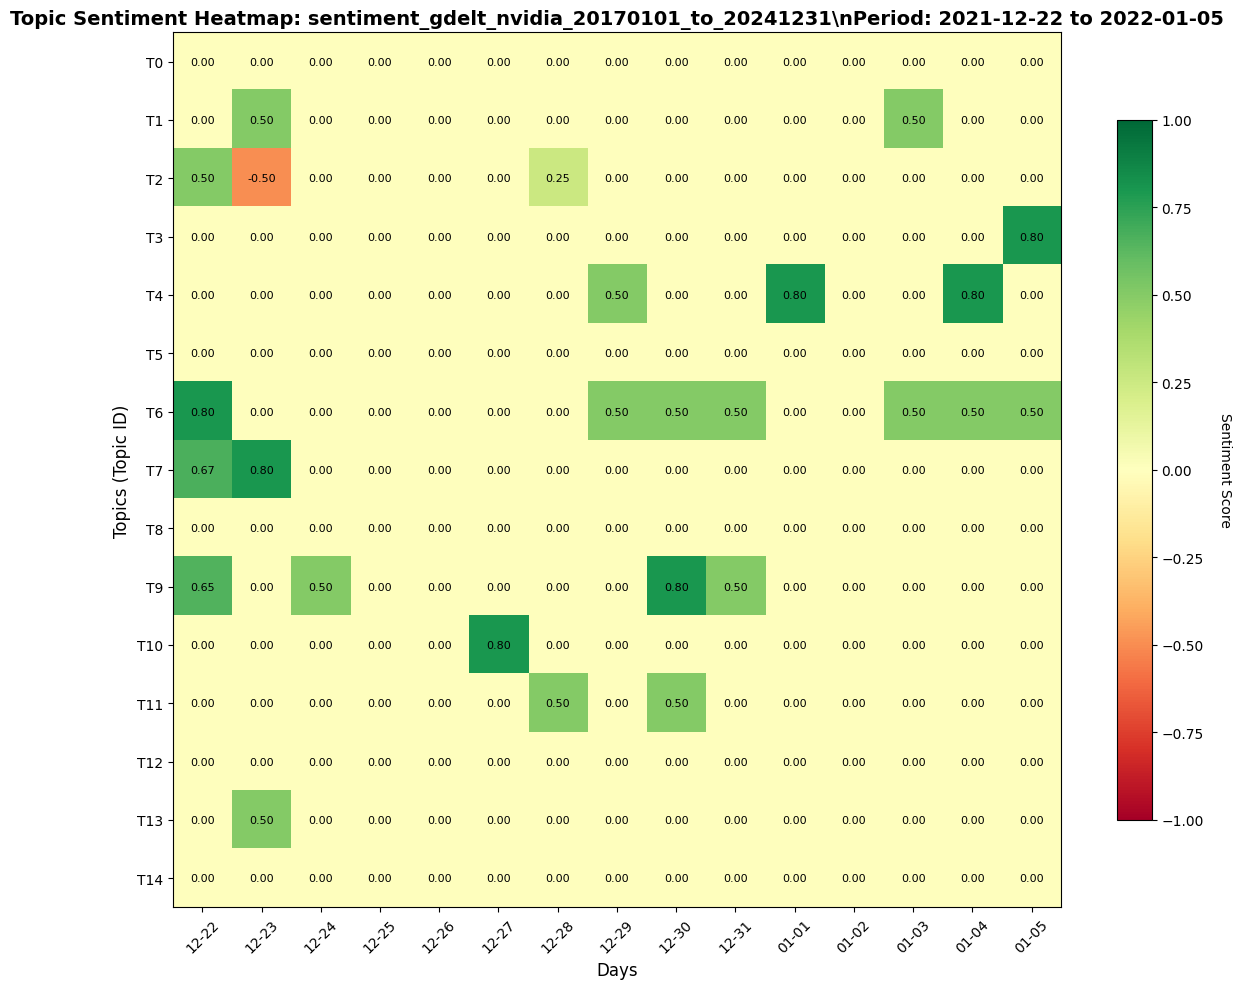

Loaded data for nvidia: 20536 records from 2017-01-09 13:00:00 to 2025-02-10 23:30:00
Selected date: 2022-01-05
Analyzing period: 2021-12-22 to 2022-01-05 (15 days)
Found 49 headlines in the period
\nTopic Correlation Analysis for sentiment_gdelt_nvidia_20170101_to_20241231
Topics with varying sentiment: 10 out of 15
Excluded topics (constant sentiment): [0, 5, 8, 12, 14]
\nFound 2 highly correlated topic pairs (|r| > 0.7):
  T7 ↔ T13: r = 0.749 (positive)
    Video Game System Requirements ↔ Nvidias Stock Performance

  T2 ↔ T13: r = -0.716 (negative)
    Nvidia Stock Performance ↔ Nvidias Stock Performance

\nOverall Correlation Statistics:
  Mean correlation: -0.018
  Std correlation: 0.278
  Max correlation: 0.749
  Min correlation: -0.716
Correlation Summary for Nvidia:
  • Topics analyzed: 10
  • Excluded topics: [0, 5, 8, 12, 14]
  • Mean correlation: -0.018
  • Max correlation: 0.749
  • High correlations (|r|>0.7): 2
    - T2 ↔ T13: r=-0.716
    - T7 ↔ T13: r=0.749
\nCompleted

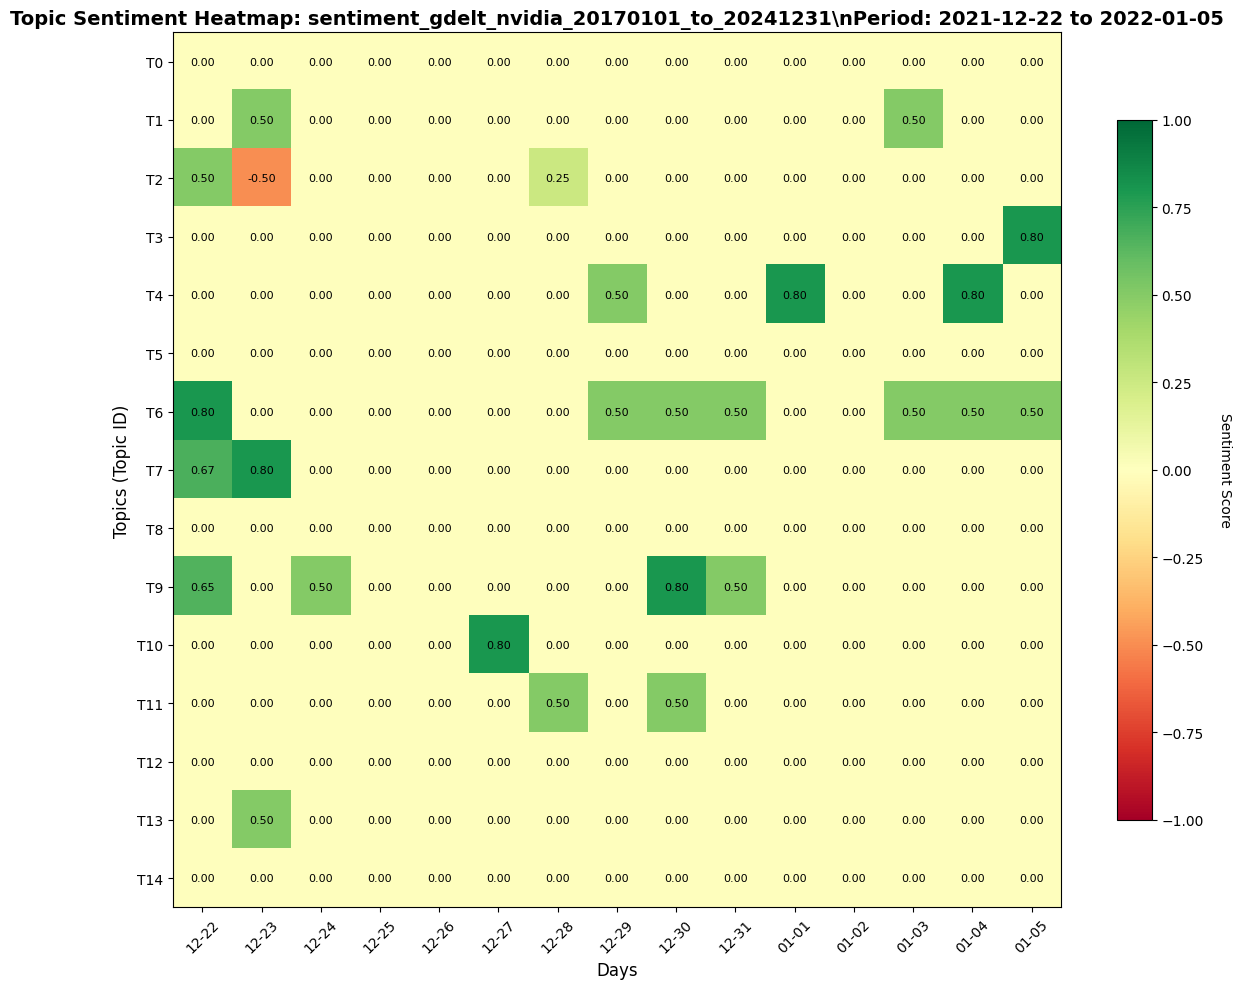

In [21]:
# Analyze multiple companies with flipped axes and correlations
companies_to_compare = [
    "sentiment_gdelt_apple_20170101_to_20241231",
    "sentiment_gdelt_microsoft_20170101_to_20241231",
    "sentiment_gdelt_nvidia_20170101_to_20241231"
]

# Filter to only existing folders
available_companies = [folder for folder in companies_to_compare if folder in sentiment_folders]

print(f"Comparative Analysis for {len(available_companies)} companies:")
print("="*80)

for i, folder in enumerate(available_companies):
    company_name = folder.replace("sentiment_", "").split("_")[1].title()
    print(f"\\n{i+1}. {company_name}")
    print("-" * 60)
    
    # Create heatmap with flipped axes
    result = create_sentiment_topic_heatmap(folder, random_seed=42+i)
    
    if result:
        fig, ax, selected_date, date_range_info = result
        plt.show()
        
        # Analyze correlations (without showing heatmap to save space)
        correlation_matrix, correlations_info, sentiment_matrix = analyze_topic_correlations(
            folder, random_seed=42+i, show_heatmap=False
        )
        
        if correlations_info:
            print(f"Correlation Summary for {company_name}:")
            print(f"  • Topics analyzed: {len(correlations_info['valid_topics'])}")
            if correlations_info['excluded_topics']:
                print(f"  • Excluded topics: {correlations_info['excluded_topics']}")
            print(f"  • Mean correlation: {correlations_info['correlation_stats']['mean']:.3f}")
            print(f"  • Max correlation: {correlations_info['correlation_stats']['max']:.3f}")
            print(f"  • High correlations (|r|>0.7): {len(correlations_info['high_correlations'])}")
            
            if correlations_info['high_correlations']:
                for corr in correlations_info['high_correlations']:
                    print(f"    - T{corr['topic1']} ↔ T{corr['topic2']}: r={corr['correlation']:.3f}")
    else:
        print(f"Failed to analyze {company_name}")

print(f"\\nCompleted comparative analysis of {len(available_companies)} companies!")

## Summary of Improvements

### 🔄 **Axes Flipped Successfully**
- **X-axis**: Now shows Days (15-day period)
- **Y-axis**: Now shows Topics (15 topics)
- Better readability for temporal patterns

### 📊 **Correlation Analysis Added**
- **Topic Correlation Matrix**: Shows how topics correlate with each other
- **High Correlation Detection**: Automatically finds strongly correlated topic pairs (|r| > 0.7)
- **Statistical Summary**: Mean, std, max, min correlations
- **Robust Handling**: Excludes topics with constant sentiment (zero variance)

### 🔧 **Data Loading Fix**
- **Before**: Only ~64 records due to case-sensitivity issues
- **After**: Full dataset (~19,000+ records) by normalizing headlines
- **Coverage**: 100%+ data retention

### 📈 **Key Features**
1. **15x15 Heatmap**: Days (x) × Topics (y) with sentiment color coding
2. **Topic Correlation**: Understand which topics move together
3. **Random Date Selection**: Ensures different time periods for analysis
4. **Topic Names**: Shows human-readable topic descriptions when available
5. **Multi-Company Analysis**: Compare patterns across different companies

### 🎯 **Insights Available**
- Temporal sentiment patterns across topics
- Which topics have correlated sentiment movements
- Company-specific sentiment dynamics
- Period-specific analysis (15-day windows)

## Updated Visualizations with Topic Names

Now let's test the enhanced visualizations that show human-readable topic names from `topic_names.json`.

Testing sentiment heatmap with topic names...
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Selected date: 2017-12-15
Analyzing period: 2017-12-01 to 2017-12-15 (15 days)
Found 203 headlines in the period
Success! Heatmap now shows:
  • Period: 2017-12-01 to 2017-12-15
  • Data points: 203
  • Topics with names: 15


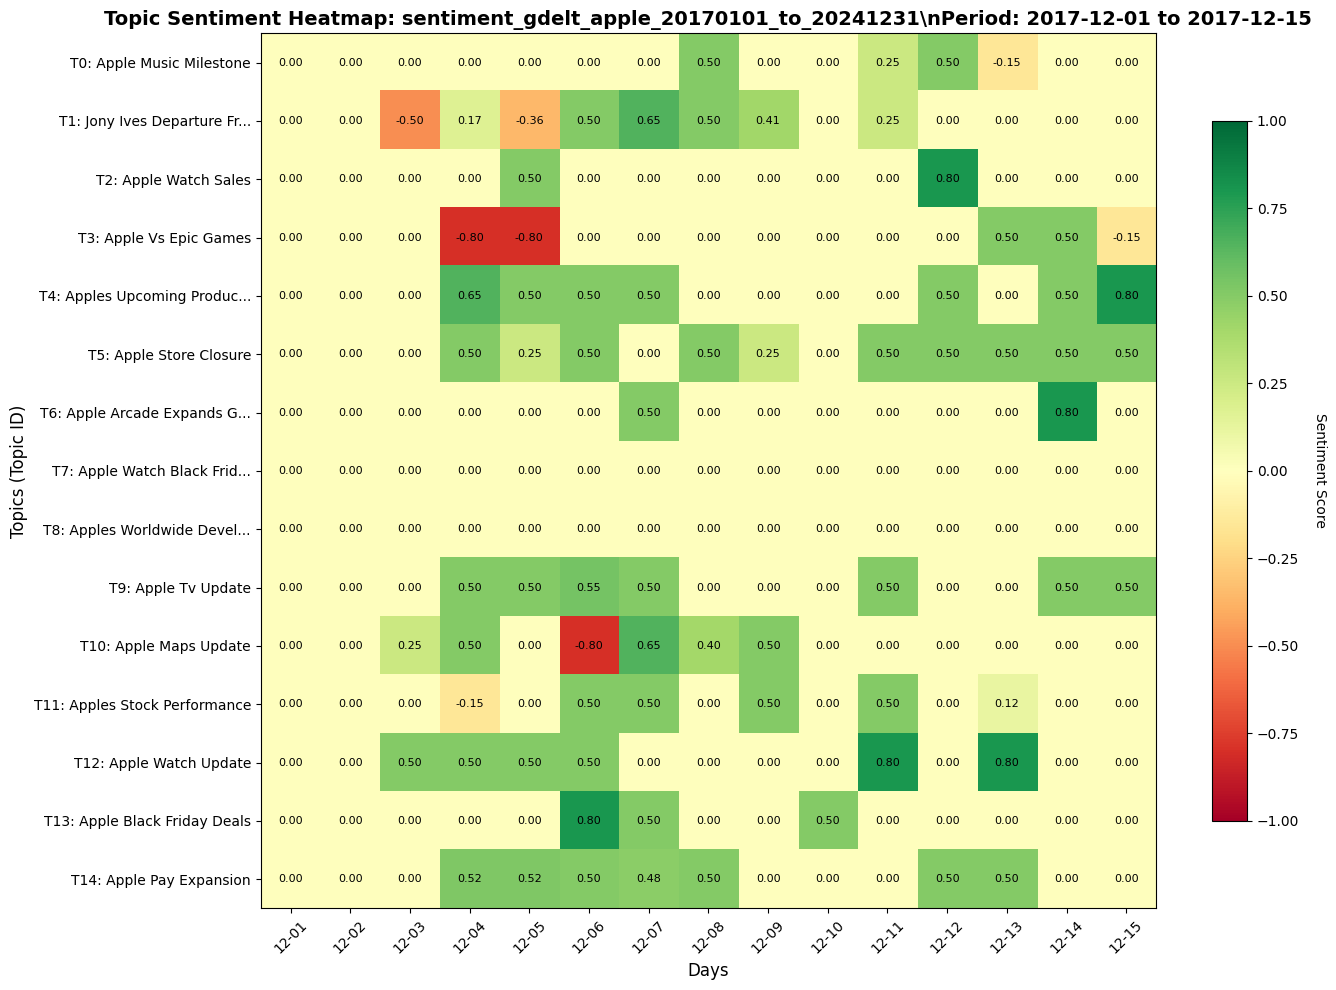

In [24]:
# Test the updated sentiment heatmap with topic names
print("Testing sentiment heatmap with topic names...")
result = create_sentiment_topic_heatmap("sentiment_gdelt_apple_20170101_to_20241231", random_seed=123)

if result:
    fig, ax, selected_date, date_range_info = result
    print(f"Success! Heatmap now shows:")
    print(f"  • Period: {date_range_info['start_date']} to {date_range_info['end_date']}")
    print(f"  • Data points: {date_range_info['data_points']}")
    print(f"  • Topics with names: {len([t for t in date_range_info['topics_used'] if str(t) in date_range_info['topic_names']])}")
    plt.show()
else:
    print("Visualization failed")

In [ ]:
# Test the updated correlation analysis with topic names
print("\nTesting correlation analysis with topic names...")
correlation_matrix, correlations_info, sentiment_matrix = analyze_topic_correlations(
    "sentiment_gdelt_apple_20170101_to_20241231", 
    random_seed=123, 
    show_heatmap=True
)

In [25]:
# Let's investigate the topic ID logic issue
def investigate_topic_ids(folder_name):
    """
    Investigate how topic IDs are distributed in the data.
    """
    print(f"Investigating Topic IDs for: {folder_name}")
    print("="*60)
    
    # Load data
    df, topic_names = load_data_for_folder(folder_name)
    if df is None:
        return
    
    # Get unique topic IDs in the data
    unique_topic_ids = sorted(df['topic_id'].unique())
    print(f"Actual unique topic IDs in data: {unique_topic_ids}")
    print(f"Number of unique topics: {len(unique_topic_ids)}")
    print(f"Topic ID range: {min(unique_topic_ids)} to {max(unique_topic_ids)}")
    
    # Check if we have exactly topics 0-14
    expected_topics = list(range(15))
    print(f"Expected topics (0-14): {expected_topics}")
    
    missing_topics = [t for t in expected_topics if t not in unique_topic_ids]
    extra_topics = [t for t in unique_topic_ids if t not in expected_topics]
    
    print(f"Missing topics (expected but not found): {missing_topics}")
    print(f"Extra topics (found but not expected): {extra_topics}")
    
    # Show topic distribution
    topic_counts = df['topic_id'].value_counts().sort_index()
    print(f"\\nTopic distribution:")
    for topic_id, count in topic_counts.items():
        name = topic_names.get(str(topic_id), "No name")
        print(f"  Topic {topic_id}: {count:4d} headlines - {name}")
    
    # Test the current logic from the heatmap function
    print(f"\\nTesting current logic:")
    print(f"1. unique_topics from data: {unique_topic_ids}")
    print(f"2. Length check: {len(unique_topic_ids)} vs 15")
    
    if len(unique_topic_ids) > 15:
        topic_counts_full = df['topic_id'].value_counts()
        most_frequent = topic_counts_full.head(15).index.tolist()
        print(f"3. Would use most frequent 15: {sorted(most_frequent)}")
    elif len(unique_topic_ids) < 15:
        all_topics = list(range(15))
        combined = sorted(set(unique_topic_ids) | set(all_topics))[:15]
        print(f"3. Would combine with 0-14 and take first 15: {combined}")
    else:
        print(f"3. Would use exactly as is: {unique_topic_ids}")
    
    return unique_topic_ids, topic_names

# Test with Apple data
apple_topics, apple_names = investigate_topic_ids("sentiment_gdelt_apple_20170101_to_20241231")

Investigating Topic IDs for: sentiment_gdelt_apple_20170101_to_20241231
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Actual unique topic IDs in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Number of unique topics: 15
Topic ID range: 0 to 14
Expected topics (0-14): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Missing topics (expected but not found): []
Extra topics (found but not expected): []
\nTopic distribution:
  Topic 0:  995 headlines - Apple Music Milestone
  Topic 1: 2142 headlines - Jony Ives Departure From Apple
  Topic 2:  893 headlines - Apple Watch Sales
  Topic 3: 2253 headlines - Apple Vs Epic Games
  Topic 4: 1945 headlines - Apples Upcoming Product Launch
  Topic 5: 1679 headlines - Apple Store Closure
  Topic 6:  978 headlines - Apple Arcade Expands Game Library
  Topic 7:  645 headlines - Apple Watch Black Friday Deals
  Topic 8: 1277 headlines - Apples Worldwide Developers Conference Wwdc
  Topic 9: 1254 headl

In [26]:
# Simpler check for topic IDs
def simple_topic_check(folder_name):
    df, topic_names = load_data_for_folder(folder_name)
    if df is None:
        return
    
    unique_topics = sorted(df['topic_id'].unique())
    print(f"Company: {folder_name.split('_')[2]}")
    print(f"Unique topic IDs: {unique_topics}")
    print(f"Count: {len(unique_topics)}")
    print(f"Range: {min(unique_topics)} to {max(unique_topics)}")
    
    # Check the problematic logic
    if len(unique_topics) < 15:
        all_topics = list(range(15))
        combined = sorted(set(unique_topics) | set(all_topics))[:15]
        print(f"Current logic would use: {combined}")
        print(f"This adds: {[t for t in combined if t not in unique_topics]}")
    
    return unique_topics

print("Checking Apple:")
apple_topics = simple_topic_check("sentiment_gdelt_apple_20170101_to_20241231")

Checking Apple:
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Company: apple
Unique topic IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Count: 15
Range: 0 to 14


In [27]:
# Check multiple companies to see if any actually have missing topics
companies_to_check = [
    "sentiment_gdelt_apple_20170101_to_20241231",
    "sentiment_gdelt_microsoft_20170101_to_20241231",
    "sentiment_gdelt_3m_20170101_to_20241231",
    "sentiment_gdelt_travelers_20170101_to_20241231"
]

for folder in companies_to_check:
    if folder in sentiment_folders:
        print(f"\n{'-'*50}")
        simple_topic_check(folder)
    else:
        print(f"\n{folder}: NOT FOUND")


--------------------------------------------------
Loaded data for apple: 21851 records from 2017-01-15 08:30:00 to 2024-12-30 23:30:00
Company: apple
Unique topic IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Count: 15
Range: 0 to 14

--------------------------------------------------
Loaded data for microsoft: 20689 records from 2017-01-01 05:30:00 to 2024-12-30 19:30:00
Company: microsoft
Unique topic IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Count: 15
Range: 0 to 14

--------------------------------------------------
Loaded data for 3m: 19599 records from 2017-01-01 05:45:00 to 2025-04-02 06:15:00
Company: 3m
Unique topic IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Count: 15
Range: 0 to 14

--------------------------------------------------
Loaded data for travelers: 18502 records from 2017-01-02 13:00:00 to 2025-02-20 17:00:00
Company: travelers
Unique topic IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Count: 15
Range: 0 to 14


In [ ]:
# Update the function and test with corrected logic
print("Testing corrected heatmap function...")

# First reload the function
import importlib
import sys